### **HOME CREDIT DEFAULT RISK PROJECT** ###

Many people struggle to get loans due to insufficient or non-existent credit histories. Unfortunately, this often leads to financial exclusion, making it difficult for individuals to access essential services and improve their living standards. Home Credit aims to address this issue by providing loans to individuals with limited or no credit history, thereby promoting financial inclusion.

The primary objective of this project is to develop a predictive model that can accurately assess the home credit risk of loan applicants. By leveraging machine learning techniques and analyzing various features from the applicants' data, we aim to identify patterns and factors that contribute to default risk. This will enable Home Credit to make informed lending decisions, reduce default rates, and extend credit to a broader population.

For this project we need a bunch of tools and libraries to work with data, perform numerical computations, and create visualizations. Below is a list of all the imports to the notebook.

In [1]:
import logging
import os
import random
import shutil
import tempfile
import warnings

import category_encoders as ce
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns
import shap
import statsmodels.api as sm
import xgboost as xg
from BorutaShap import BorutaShap
from catboost import CatBoostClassifier
from joblib import Memory, Parallel, delayed
from lightgbm import LGBMClassifier
from optuna.pruners import HyperbandPruner
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from ydata_profiling import ProfileReport

warnings.filterwarnings("ignore", category=UserWarning, module="shap")
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.simplefilter("ignore", category=FutureWarning)
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [2]:
import sys

sys.path.append(os.path.abspath(".."))
from ml_app.app_utils.custom_transformers import (
    CategoricalAggregator,
    CategoricalConverter,
    DaysToYearsTransformer,
    FeatureDropper,
    FeatureInteractionsBorutaDeploy,
    NewFeatureEngineerDeploy,
    NumericDowncaster,
    OutlierSkewTransformer,
    TableMerger,
)
from utils import utils
from utils.plot_style import set_notebook_style
from utils.transformers import (
    CustomImputer,
    FeatureInteractions,
    FeatureInteractionsBoruta,
    LowVarianceDropper,
    NewFeatureEngineer,
    PhikSelector,
)

set_notebook_style()

In [3]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 50)
pd.set_option("future.no_silent_downcasting", True)

#### **Investigation and Modeling Plan: Home Credit Default Risk** ####

**Assumptions**  
* The application train data and helper tables sufficiently represent client financial behavior and default risk.

* Missing values may carry predictive information and are not purely random.

* Data can have anomalies and outliers that need to be addressed during data preprocessing.

* High cardinality categorical features require specialized preprocessing and encoding to preserve signal and avoid model overfitting.

* Feature relevance and interactions significantly influence model performance and require iterative selection.

* Computational resource constraints necessitate using data type optimization.

**Overall Objective**  
* Develop a robust binary classification model to predict default risk, maximizing predictive accuracy (ROC AUC) while ensuring scalability and deployability in production systems.

**Stepwise Plan**  

*Step 1: Initial Data Profiling*
* Utilize YData Profiling on application train dataset to identify distributions, missingness, and anomalies.

* Investigate helper tables to assess data quality and completeness.

**Goal**: Gain foundational understanding of data characteristics and potential data issues.

*Step 2: Feature Preprocessing and Selection*
* Develop transformers for high cardinality categorical feature aggregations to broader groups.

* Identify and remove low variance features to reduce noise and dimensionality.

* Develop transformers to handle outliers, skewness of the distributions and data anomalies.

* Compute Phik correlation matrix to filter out features weakly correlated with the target variable.

**Goal**: Prepare a clean, relevant feature set for modeling.

*Step 3: Advanced Feature Selection*
* Apply Boruta SHAP feature selection using a LightGBM model to identify the most influential features, balancing predictive power and complexity.

* Downcast numerical features to appropriate data types to economize memory and speed up computations.

**Goal**: Obtain a focused, resource-efficient set of predictive features.

*Step 4: Baseline Modeling and Evaluation*
* Train Logistic Regression model to establish a baseline predictive performance.

* Evaluate results with ROC AUC.

**Goal**: Establish a robust baseline model and performance benchmark.

*Step 5: Statistical Inference and Correlation Analysis*
* Conduct statistical tests (e.g., Chi-Squared, permutation) to validate feature significance.

* Analyze feature correlations to identify multicollinearity and redundant features.

**Goal**: Ensure selected features are statistically valid and non-redundant.

*Step 6: Feature Interaction Engineering*
* Engineer interaction features among the top selected variables to capture nonlinear dependencies.

* Re-run Boruta SHAP selection to isolate most impactful interaction features.

**Goal**: Enhance model expressiveness and predictive performance.

*Step 7: Model Tuning and Validation*
* Tune model hyperparameters using Bayesian optimization (Optuna) with cross-validation.

* Evaluate tuning results visually and quantitatively (ROC AUC curves, validation set scores).

**Goal**: Maximize model generalization and stability.

*Step 8: Model Testing and Deployment*
* Assess performance on holdout and test datasets to confirm real-world effectiveness.

* Deploy the best-performing model using FastAPI and Docker to Google Cloud Platform, enabling scalable production use.

**Goal**: Transition from experimentation to production-ready predictive solution.

#### **Exploratory Data Analysis** ####

Home Credit Default Risk dataset consists of a main application_train.csv table and several helper tables.

We will load CSV format files to Parquet format for better performance, since Parquet is columnar, compressed and efficient for querying with DuckDB using SQL.

In this notebook we will explore application_train.csv file. There are additional notebooks to explore and aggregate helper tables:

**credits.ipynb**:
* bureau.csv
* bureau_balance.csv

**prev_application.ipynb**:
* credit_card_balance.csv
* installments_payments.csv
* POS_CASH_balance.csv
* previous_application.csv

To this notebook we will load already aggregated and cleaned versions of these helper tables to join with application_train table. Also, we will load description of application_train features to understand better the data.

In [219]:
application_df = pd.read_parquet("../data/application_train.parquet")
application_df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   ...  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5 FLAG_DOCUMENT_6  \
0  ...                1                0                0               0   
1  ...                1                0                0               0   
2  ...                0                0                0               0   
3  ...                1                0                0               0   
4  ...                0                0                0               0   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9 FLAG_DOCUMENT_10  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                1                0                0   

   FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   F

In [5]:
print(
    f"Train dataset has {application_df.shape[0]} rows and {application_df.shape[1]} columns."
)

Train dataset has 307511 rows and 122 columns.


In [6]:
description = pd.read_csv(
    "../data/HomeCredit_columns_description.csv", encoding="ISO-8859-1", index_col=0
)
description[description["Table"].str.startswith("application_")]

Table                           Row  \
1    application_{train|test}.csv                    SK_ID_CURR   
2    application_{train|test}.csv                        TARGET   
5    application_{train|test}.csv            NAME_CONTRACT_TYPE   
6    application_{train|test}.csv                   CODE_GENDER   
7    application_{train|test}.csv                  FLAG_OWN_CAR   
8    application_{train|test}.csv               FLAG_OWN_REALTY   
9    application_{train|test}.csv                  CNT_CHILDREN   
10   application_{train|test}.csv              AMT_INCOME_TOTAL   
11   application_{train|test}.csv                    AMT_CREDIT   
12   application_{train|test}.csv                   AMT_ANNUITY   
13   application_{train|test}.csv               AMT_GOODS_PRICE   
14   application_{train|test}.csv               NAME_TYPE_SUITE   
15   application_{train|test}.csv              NAME_INCOME_TYPE   
16   application_{train|test}.csv           NAME_EDUCATION_TYPE   
17   application_{train|test}.csv            NAME_FAMILY_STATUS   
18   application_{train|test}.csv             NAME_HOUSING_TYPE   
19   application_{train|test}.csv    REGION_POPULATION_RELATIVE   
20   application_{train|test}.csv                    DAYS_BIRTH   
21   application_{train|test}.csv                 DAYS_EMPLOYED   
22   application_{train|test}.csv             DAYS_REGISTRATION   
23   application_{train|test}.csv               DAYS_ID_PUBLISH   
24   application_{train|test}.csv                   OWN_CAR_AGE   
25   application_{train|test}.csv                    FLAG_MOBIL   
26   application_{train|test}.csv                FLAG_EMP_PHONE   
27   application_{train|test}.csv               FLAG_WORK_PHONE   
28   application_{train|test}.csv              FLAG_CONT_MOBILE   
29   application_{train|test}.csv                    FLAG_PHONE   
30   application_{train|test}.csv                    FLAG_EMAIL   
31   application_{train|test}.csv               OCCUPATION_TYPE   
32   application_{train|test}.csv               CNT_FAM_MEMBERS   
33   application_{train|test}.csv          REGION_RATING_CLIENT   
34   application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
35   application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
36   application_{train|test}.csv       HOUR_APPR_PROCESS_START   
37   application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
38   application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
39   application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
40   application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
41   application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
42   application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
43   application_{train|test}.csv             ORGANIZATION_TYPE   
44   application_{train|test}.csv                  EXT_SOURCE_1   
45   application_{train|test}.csv                  EXT_SOURCE_2   
46   application_{train|test}.csv                  EXT_SOURCE_3   
47   application_{train|test}.csv                APARTMENTS_AVG   
48   application_{train|test}.csv              BASEMENTAREA_AVG   
49   application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
50   application_{train|test}.csv               YEARS_BUILD_AVG   
51   application_{train|test}.csv                COMMONAREA_AVG   
52   application_{train|test}.csv                 ELEVATORS_AVG   
53   application_{train|test}.csv                 ENTRANCES_AVG   
54   application_{train|test}.csv                 FLOORSMAX_AVG   
55   application_{train|test}.csv                 FLOORSMIN_AVG   
56   application_{train|test}.csv                  LANDAREA_AVG   
57   application_{train|test}.csv          LIVINGAPARTMENTS_AVG   
58   application_{train|test}.csv                LIVINGAREA_AVG   
59   application_{train|test}.csv       NONLIVINGAPARTMENTS_AVG   
60   application_{train|test}.csv             NONLIVINGAREA_AVG   
61   application_{train|test}.csv               APARTMENTS_MODE   
62   app

We must check for duplicated values in the application_train table and if there are duplicated SK_ID_CURR.

In [7]:
print(
    f"There are {application_df.duplicated().sum()} duplicated rows in the application data."
)
print(
    f"There are {application_df.duplicated(subset=['SK_ID_CURR']).sum()} duplicated SK_ID_CURR."
)

There are 0 duplicated rows in the application data.
There are 0 duplicated SK_ID_CURR.


Using Ydata Profiling we have created an initial report of the application_train table to understand better the data, distributions, missing values and possible anomalies, which we will address in the next steps of the project.

In [ ]:
profile_application = ProfileReport(application_df.sample(50_000),
                                    title="Home Credit Profiling Report",
                                    correlations={
                                        "phi_k": {"calculate": True},
                                    },
                                    explorative=True)

profile_application.to_file("../reports/application_data_profiling_50k.html")

From application_train dataset overview with YData Profiling tool (taking 50k sample) it is noticed that:
* most loans are cash loans;
* most debtors are women;
* most do not have a car, own a house or a flat, are married, and do not have children;
* AMT_INCOME_TOTAL is highly positively skewed;
* AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE are also positively skewed;
* most debtors came alone to apply for a loan;
* most are working persons, having secondary education;
* average age is ~44 years old.

The features that need more thorough analysis will be investigated in the next steps. For our model not be discriminating in any way, we won't use gender feature in our model.

We will split the data into train and test set using stratified sampling to keep the same proportion of target variable in both sets. Exploratory Data Analysis (EDA) will be performed on the training set only to avoid data leakage.

In [220]:
y = application_df.pop("TARGET")
X = application_df
print(
    f"Shape of the target series: {y.shape}, shape of the predictors' matrix: {X.shape}"
)

Shape of the target series: (307511,), shape of the predictors' matrix: (307511, 121)


In [221]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

Missingness analysis will be performed to identify features with high missing rates. We need to check what missingness ratio is maximum in our dataset. Features with more than 80% missing values would be considered for removal. 

In [11]:
missing_df = (
    application_df.isnull()
    .sum()
    .reset_index()
    .rename(columns={"index": "feature", 0: "missing_count"})
)
missing_df["missing_ratio"] = round(
    missing_df["missing_count"] / len(application_df) * 100, 1
)
missing = missing_df.sort_values("missing_ratio", ascending=False).reset_index(
    drop=True
)

max_missing_ratio = missing_df["missing_ratio"].max()
print(
    f"""Maximum missingness ratio in our dataset is {max_missing_ratio}.
So there is no feature with more than 80% missing values."""
)

Maximum missingness ratio in our dataset is 69.9.
So there is no feature with more than 80% missing values.


Let's check which features have the highest number of missing values and their percentage in the dataset.

In [12]:
missing_df[missing_df["missing_ratio"] > np.floor(max_missing_ratio)]

feature  missing_count  missing_ratio
47            COMMONAREA_AVG         214865           69.9
55   NONLIVINGAPARTMENTS_AVG         213514           69.4
61           COMMONAREA_MODE         214865           69.9
69  NONLIVINGAPARTMENTS_MODE         213514           69.4
75           COMMONAREA_MEDI         214865           69.9
83  NONLIVINGAPARTMENTS_MEDI         213514           69.4

 Next we will explore which features do not have any missing values, a moderate amount of missingness (up to 20%) and high missingness (more than 20%).

In [13]:
missing_df[missing_df["missing_ratio"] == 0].shape[0]
missing_df[missing_df["missing_ratio"] == 0]

feature  missing_count  missing_ratio
0                     SK_ID_CURR              0            0.0
1             NAME_CONTRACT_TYPE              0            0.0
2                    CODE_GENDER              0            0.0
3                   FLAG_OWN_CAR              0            0.0
4                FLAG_OWN_REALTY              0            0.0
5                   CNT_CHILDREN              0            0.0
6               AMT_INCOME_TOTAL              0            0.0
7                     AMT_CREDIT              0            0.0
8                    AMT_ANNUITY             12            0.0
11              NAME_INCOME_TYPE              0            0.0
12           NAME_EDUCATION_TYPE              0            0.0
13            NAME_FAMILY_STATUS              0            0.0
14             NAME_HOUSING_TYPE              0            0.0
15    REGION_POPULATION_RELATIVE              0            0.0
16                    DAYS_BIRTH              0            0.0
17                 DAYS_EMPLOYED              0            0.0
18             DAYS_REGISTRATION              0            0.0
19               DAYS_ID_PUBLISH              0            0.0
21                    FLAG_MOBIL              0            0.0
22                FLAG_EMP_PHONE              0            0.0
23               FLAG_WORK_PHONE              0            0.0
24              FLAG_CONT_MOBILE              0            0.0
25                    FLAG_PHONE              0            0.0
26                    FLAG_EMAIL              0            0.0
28               CNT_FAM_MEMBERS              2            0.0
29          REGION_RATING_CLIENT              0            0.0
30   REGION_RATING_CLIENT_W_CITY              0            0.0
31    WEEKDAY_APPR_PROCESS_START              0            0.0
32       HOUR_APPR_PROCESS_START              0            0.0
33    REG_REGION_NOT_LIVE_REGION              0            0.0
34    REG_REGION_NOT_WORK_REGION              0            0.0
35   LIVE_REGION_NOT_WORK_REGION              0            0.0
36        REG_CITY_NOT_LIVE_CITY              0            0.0
37        REG_CITY_NOT_WORK_CITY              0            0.0
38       LIVE_CITY_NOT_WORK_CITY              0            0.0
39             ORGANIZATION_TYPE              0            0.0
94        DAYS_LAST_PHONE_CHANGE              1            0.0
95               FLAG_DOCUMENT_2              0            0.0
96               FLAG_DOCUMENT_3              0            0.0
97               FLAG_DOCUMENT_4              0            0.0
98               FLAG_DOCUMENT_5              0            0.0
99               FLAG_DOCUMENT_6              0            0.0
100              FLAG_DOCUMENT_7              0            0.0
101              FLAG_DOCUMENT_8              0            0.0
102              FLAG_DOCUMENT_9              0            0.0
103             FLAG_DOCUMENT_10              0            0.0
104             FLAG_DOCUMENT_11              0            0.0
105             FLAG_DOCUMENT_12              0            0.0
106             FLAG_DOCUMENT_13              0            0.0
107             FLAG_DOCUMENT_14              0            0.0
108             FLAG_DOCUMENT_15              0            0.0
109             FLAG_DOCUMENT_16              0            0.0
110             FLAG_DOCUMENT_17              0            0.0
111             FLAG_DOCUMENT_18              0            0.0
112             FLAG_DOCUMENT_19              0            0.0
113             FLAG_DOCUMENT_20              0            0.0
114             FLAG_DOCUMENT_21              0            0.0

In [14]:
missing_df[(missing_df["missing_ratio"] > 0) & (missing_df["missing_ratio"] < 20)]

feature  missing_count  missing_ratio
9               AMT_GOODS_PRICE            278            0.1
10              NAME_TYPE_SUITE           1292            0.4
41                 EXT_SOURCE_2            660            0.2
42                 EXT_SOURCE_3          60965           19.8
90     OBS_30_CNT_SOCIAL_CIRCLE           1021            0.3
91     DEF_30_CNT_SOCIAL_CIRCLE           1021            0.3
92     OBS_60_CNT_SOCIAL_CIRCLE           1021            0.3
93     DEF_60_CNT_SOCIAL_CIRCLE           1021            0.3
115  AMT_REQ_CREDIT_BUREAU_HOUR          41519           13.5
116   AMT_REQ_CREDIT_BUREAU_DAY          41519           13.5
117  AMT_REQ_CREDIT_BUREAU_WEEK          41519           13.5
118   AMT_REQ_CREDIT_BUREAU_MON          41519           13.5
119   AMT_REQ_CREDIT_BUREAU_QRT          41519           13.5
120  AMT_REQ_CREDIT_BUREAU_YEAR          41519           13.5

In [15]:
missing_df[missing_df["missing_ratio"] > 20]

feature  missing_count  missing_ratio
20                   OWN_CAR_AGE         202929           66.0
27               OCCUPATION_TYPE          96391           31.3
40                  EXT_SOURCE_1         173378           56.4
43                APARTMENTS_AVG         156061           50.7
44              BASEMENTAREA_AVG         179943           58.5
45   YEARS_BEGINEXPLUATATION_AVG         150007           48.8
46               YEARS_BUILD_AVG         204488           66.5
47                COMMONAREA_AVG         214865           69.9
48                 ELEVATORS_AVG         163891           53.3
49                 ENTRANCES_AVG         154828           50.3
50                 FLOORSMAX_AVG         153020           49.8
51                 FLOORSMIN_AVG         208642           67.8
52                  LANDAREA_AVG         182590           59.4
53          LIVINGAPARTMENTS_AVG         210199           68.4
54                LIVINGAREA_AVG         154350           50.2
55       NONLIVINGAPARTMENTS_AVG         213514           69.4
56             NONLIVINGAREA_AVG         169682           55.2
57               APARTMENTS_MODE         156061           50.7
58             BASEMENTAREA_MODE         179943           58.5
59  YEARS_BEGINEXPLUATATION_MODE         150007           48.8
60              YEARS_BUILD_MODE         204488           66.5
61               COMMONAREA_MODE         214865           69.9
62                ELEVATORS_MODE         163891           53.3
63                ENTRANCES_MODE         154828           50.3
64                FLOORSMAX_MODE         153020           49.8
65                FLOORSMIN_MODE         208642           67.8
66                 LANDAREA_MODE         182590           59.4
67         LIVINGAPARTMENTS_MODE         210199           68.4
68               LIVINGAREA_MODE         154350           50.2
69      NONLIVINGAPARTMENTS_MODE         213514           69.4
70            NONLIVINGAREA_MODE         169682           55.2
71               APARTMENTS_MEDI         156061           50.7
72             BASEMENTAREA_MEDI         179943           58.5
73  YEARS_BEGINEXPLUATATION_MEDI         150007           48.8
74              YEARS_BUILD_MEDI         204488           66.5
75               COMMONAREA_MEDI         214865           69.9
76                ELEVATORS_MEDI         163891           53.3
77                ENTRANCES_MEDI         154828           50.3
78                FLOORSMAX_MEDI         153020           49.8
79                FLOORSMIN_MEDI         208642           67.8
80                 LANDAREA_MEDI         182590           59.4
81         LIVINGAPARTMENTS_MEDI         210199           68.4
82               LIVINGAREA_MEDI         154350           50.2
83      NONLIVINGAPARTMENTS_MEDI         213514           69.4
84            NONLIVINGAREA_MEDI         169682           55.2
85            FONDKAPREMONT_MODE         210295           68.4
86                HOUSETYPE_MODE         154297           50.2
87                TOTALAREA_MODE         148431           48.3
88            WALLSMATERIAL_MODE         156341           50.8
89           EMERGENCYSTATE_MODE         145755           47.4

We see that features related with main aspects of client's financial status have none or just a few missing values. However, features related with the living area have more than 50% of missing values.

Let's get the whole train dataset after splitting to train and test sets for further analysis. We need to check if we have binary classification task with high data imbalance first.

In [223]:
df_train = X_train.join(y_train)

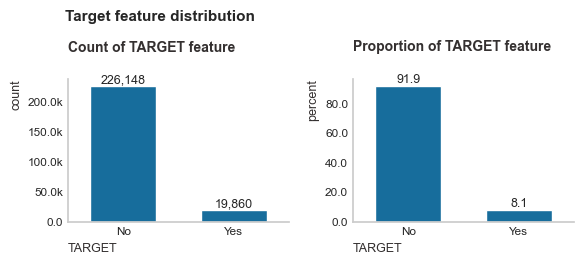

In [17]:
utils.plot_target(df_train, "TARGET", (6, 2.5), 0.28, 1.05)

We see that we have high data imbalance, with only 8% of positive class cases (defaulted loans). This needs to be addressed during modeling phase.

Next we will go through particular features which from YData profiling report seems requiring further investigation. First, it is OWN_CAR_AGE feature that has ~66% missing values. We need to check distribution of this feature to spot any anomalies.

In [18]:
df_train.groupby("TARGET")["OWN_CAR_AGE"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995]
).map(lambda x: f"{x:,.2f}")

count   mean    std   min   25%    50%    75%    95%    99%  \
TARGET                                                                    
0       77,509.00  11.93  11.86  0.00  5.00   9.00  15.00  29.00  64.00   
1        6,081.00  13.69  12.47  0.00  6.00  11.00  17.00  33.00  64.00   

        99.5%    max  
TARGET                
0       65.00  91.00  
1       65.00  91.00

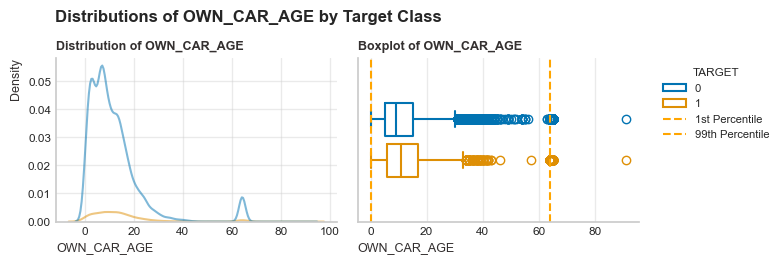

In [19]:
utils.get_distribution_plots(
    df_train,
    features=["OWN_CAR_AGE"],
    target="TARGET",
    figsize=(8, 2.5),
    title_right=0.32,
    title_top=1.05,
)

We see that this feature has some outliers with quite high values (65 years) and also like an anomaly seems a maximum value (91) of the feature. We will address this using winsorization technique during preprocessing phase, capping feature values at the 1st and 99th percentiles.

Next we will examine AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE features - their distributions and relation with the target variable.

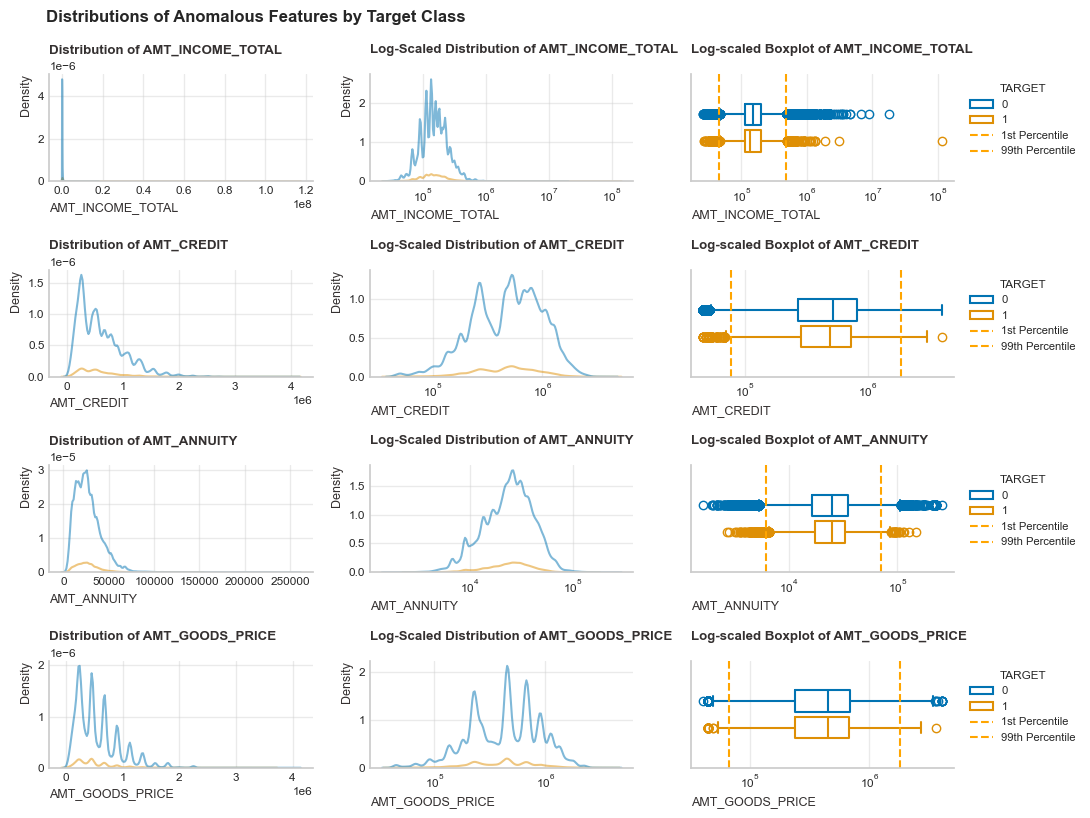

In [20]:
anomalous_amt_cols = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
]

utils.plot_distribution_log(
    df_train,
    anomalous_amt_cols,
    "TARGET",
    (11, 2 * len(anomalous_amt_cols)),
    0.24,
    1.02,
)

From the plot above we see that AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, and AMT_GOODS_PRICE features have a positively skewed distribution and many outliers. We will need to handle this skewness and outliers in the data preprocessing step using winsorization as well.

AMT_INCOME_TOTAL feature has some extreme outliers with very high income values (up to 117 million for defaulted loans). Let's examine those samples.

In [21]:
df_train.groupby("TARGET")["AMT_INCOME_TOTAL"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]
).map(lambda x: f"{x:,.2f}")

count        mean         std        min         25%         50%  \
TARGET                                                                          
0       226,148.00  169,062.45  109,181.66  25,650.00  112,500.00  148,500.00   
1        19,860.00  166,470.17  833,649.56  27,000.00  112,500.00  135,000.00   

               75%         95%         99%             max  
TARGET                                                      
0       202,500.00  337,500.00  486,000.00   18,000,090.00  
1       202,500.00  315,000.00  450,000.00  117,000,000.00

In [22]:
df_train[df_train["AMT_INCOME_TOTAL"] > 1e7]

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
12840       114967         Cash loans           F            N   
203693      336147         Cash loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
12840                Y             1       117000000.0    562491.0   
203693               Y             2        18000090.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
12840       26194.5         454500.0   Unaccompanied               Working   
203693      69295.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
12840   Secondary / secondary special            Married  House / apartment   
203693  Secondary / secondary special            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
12840                     0.010643      -12615           -922   
203693                    0.030755      -15704          -4961   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
12840             -6762.0            -3643          NaN           1   
203693            -3338.0            -4728          7.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  ...  \
12840                1                0                 1  ...   
203693               1                0                 1  ...   

        FLAG_DOCUMENT_4  FLAG_DOCUMENT_5 FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
12840                 0                0               0                0   
203693                0                0               0                0   

        FLAG_DOCUMENT_8  FLAG_DOCUMENT_9 FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
12840                 0                0                0                 0   
203693                0                0                0                 0   

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
12840                  0                 0                 0   
203693                 0                 0                 0   

        FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17 FLAG_DOCUMENT_18  \
12840                  0                 0                 0                0   
203693                 0                 0                 0                0   

        FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
12840                  0                 0                 0   
203693                 0                 0                 0   

        AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
12840                          0.0                        0.0   
203693                         NaN                        NaN   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
12840                          0.0                        0.0   
203693                         NaN                        NaN   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  TARGET  
12840                         0.0                         1.0       1  
203693                        NaN                         NaN       0  

[2 rows x 122 columns]

We see that these samples with extreme income values also have very high credit amount, and goods price. One sample defaulted, and the other did not. 

Further, let's explore CNT_CHILDREN and CNT_FAM_MEMBERS feature distributions and their relation with the target variable.

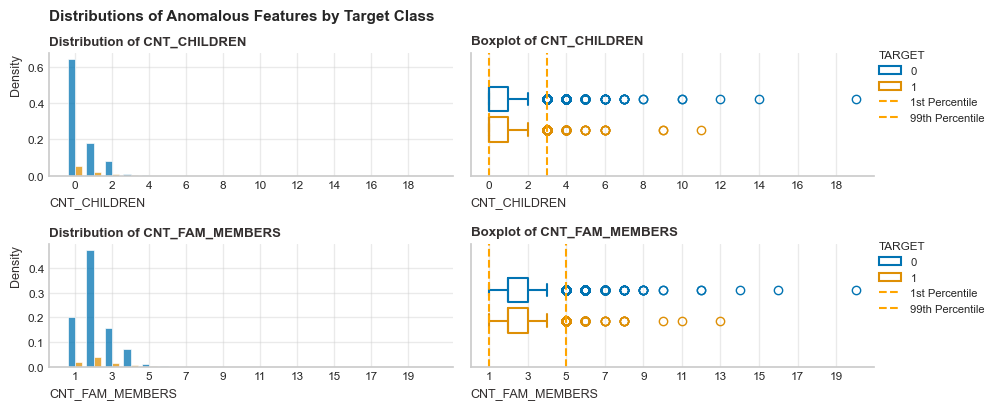

In [23]:
anomalous_cnts = ["CNT_CHILDREN", "CNT_FAM_MEMBERS"]

utils.plot_discrete_distribution(
    df_train, anomalous_cnts, "TARGET", (10, 2 * len(anomalous_cnts)), title_right=0.25
)

We see that distribution of CNT_CHILDREN feature is positively skewed, with most applicants having 0 or 2 children. There are some outliers with a high number of children (up to 19) that need to be treated. We will cap these features to 99th percentile in the data preprocessing step.

Further, there are days related features, like DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, and DAYS_ID_PUBLISH. Let's explore their distributions and relation with the target variable.

In [224]:
anomalous_time_cols = [
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
]

df_train[anomalous_time_cols].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995]
).map(lambda x: f"{x:,.2f}")

DAYS_BIRTH DAYS_EMPLOYED DAYS_REGISTRATION DAYS_ID_PUBLISH
count  246,008.00    246,008.00        246,008.00      246,008.00
mean   -16,029.52     63,581.16         -4,989.59       -2,994.15
std      4,362.87    141,081.70          3,524.56        1,508.27
min    -25,229.00    -17,912.00        -24,672.00       -7,197.00
25%    -19,673.00     -2,762.00         -7,480.00       -4,298.00
50%    -15,744.00     -1,215.00         -4,505.00       -3,255.00
75%    -12,401.00       -291.00         -2,015.00       -1,720.00
95%     -9,401.00    365,243.00           -331.00         -376.00
99%     -8,260.00    365,243.00            -51.00          -62.00
99.5%   -8,080.00    365,243.00            -20.00          -25.00
max     -7,489.00    365,243.00              0.00            0.00

In [26]:
X_train[X_train["DAYS_EMPLOYED"] > 20_000].DAYS_EMPLOYED.value_counts()

DAYS_EMPLOYED
365243    44143
Name: count, dtype: int64

We see that DAYS_EMPLOYED has 365243 value that need to be treated as a missing value. We will create a transformer to handle this anomaly in the data preprocessing step.

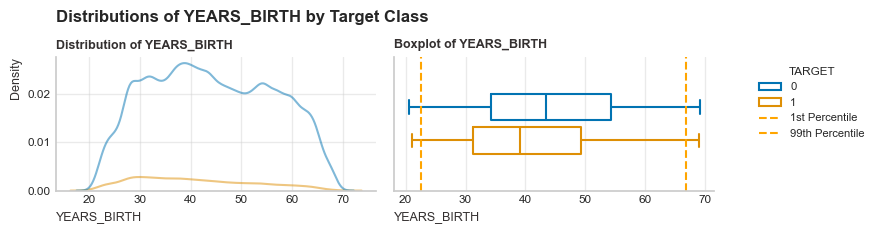

In [27]:
years_birth = X_train["DAYS_BIRTH"] / -365
target = y_train
years_birth_target_df = pd.concat([years_birth, target], axis=1).rename(
    columns={"DAYS_BIRTH": "YEARS_BIRTH"}
)
utils.get_distribution_plots(
    years_birth_target_df,
    features=["YEARS_BIRTH"],
    target="TARGET",
    figsize=(9, 2.2),
    title_right=0.285,
    title_top=1.05,
)

We see that median age of loan applicants who defaulted are younger. This feature seems to have predictive power for our model. It has no outliers.

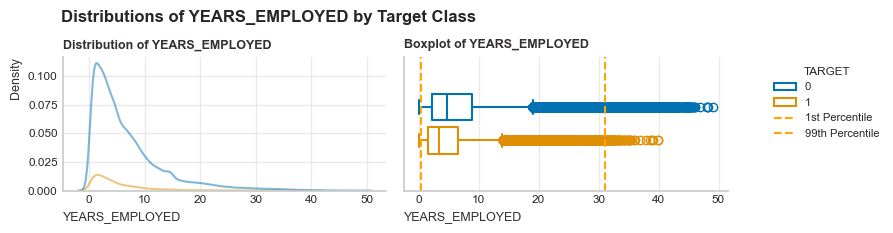

In [28]:
years_employed = (X_train["DAYS_EMPLOYED"].replace({365243: np.NAN})) / -365
years_employed_target_df = pd.concat([years_employed, target], axis=1).rename(
    columns={"DAYS_EMPLOYED": "YEARS_EMPLOYED"}
)
utils.get_distribution_plots(
    years_employed_target_df,
    features=["YEARS_EMPLOYED"],
    target="TARGET",
    figsize=(9, 2.2),
    title_right=0.3,
    title_top=1.05,
)

In [29]:
df_train.groupby("TARGET")["DAYS_EMPLOYED"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]
).map(lambda x: f"{x:,.2f}")

count       mean         std         min        25%        50%  \
TARGET                                                                        
0       226,148.00  65,477.38  142,701.53  -17,912.00  -2,815.00  -1,236.00   
1        19,860.00  41,988.79  119,009.16  -14,540.00  -2,177.00  -1,038.00   

            75%         95%         99%         max  
TARGET                                               
0       -280.00  365,243.00  365,243.00  365,243.00  
1       -380.00  365,243.00  365,243.00  365,243.00

Median years of employment for positive class (TARGET=1) is ~2.8 years, while for negative class (TARGET=0) is ~3.4 years. There are a lot of outliers with high years of employment, but seems that values are reasonable after treating 365243 as a missing value.

In [30]:
years_reg = X_train["DAYS_REGISTRATION"] / -365
years_reg_target_df = pd.concat([years_reg, target], axis=1).rename(
    columns={"DAYS_REGISTRATION": "YEARS_REGISTRATION"}
)
utils.get_distribution_plots(
    years_reg_target_df,
    features=["YEARS_REGISTRATION"],
    target="TARGET",
    figsize=(9, 2.2),
    title_right=0.32,
    title_top=1.05,
)

In [31]:
df_train.groupby("TARGET")["DAYS_REGISTRATION"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]
).map(lambda x: f"{x:,.2f}")

count       mean       std         min        25%        50%  \
TARGET                                                                      
0       226,148.00  -5,033.58  3,540.04  -24,672.00  -7,552.00  -4,546.00   
1        19,860.00  -4,488.55  3,302.18  -19,706.00  -6,638.25  -4,053.50   

              75%      95%     99%   max  
TARGET                                    
0       -2,051.00  -338.00  -53.00  0.00  
1       -1,679.00  -260.95  -34.00  0.00

Median years since registration for those who defaulted is ~11 years, on those who did not ~12.5 years. This feature may have some predictive power for our model. There are outliers with high years since registration, but they seem reasonable comparing with the range of applicants' age.

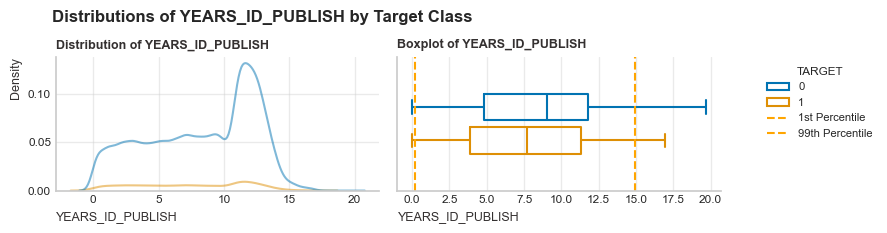

In [32]:
years_id = X_train["DAYS_ID_PUBLISH"] / -365
years_id_publish_target_df = pd.concat([years_id, target], axis=1).rename(
    columns={"DAYS_ID_PUBLISH": "YEARS_ID_PUBLISH"}
)
utils.get_distribution_plots(
    years_id_publish_target_df,
    features=["YEARS_ID_PUBLISH"],
    target="TARGET",
    figsize=(9, 2.2),
    title_right=0.3,
    title_top=1.05,
)

In [33]:
df_train.groupby("TARGET")["DAYS_ID_PUBLISH"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]
).map(lambda x: f"{x:,.2f}")

count       mean       std        min        25%        50%  \
TARGET                                                                     
0       226,148.00  -3,016.31  1,505.63  -7,197.00  -4,312.00  -3,295.00   
1        19,860.00  -2,741.80  1,515.43  -6,189.00  -4,123.00  -2,816.00   

              75%      95%     99%   max  
TARGET                                    
0       -1,753.00  -385.00  -63.00  0.00  
1       -1,405.00  -293.95  -42.00  0.00

We see that median years since ID published is slightly higher for negative class (TARGET=0). This feature may have some predictive power for our model, and has no outliers.

Next, we have about 20 Flag document features (FLAG_DOCUMENT_2 to FLAG_DOCUMENT_21). Let's explore which part of the applicants submitted those documents and how this submission rate could be related with the risk of default.

In [ ]:
flag_columns = [col for col in X_train.columns if col.startswith("FLAG_DOCUMENT")]

flag_doc_counts = (
    df_train.groupby("TARGET")[flag_columns]
    .mean()
    .reset_index()
    .melt(id_vars="TARGET", var_name="Document", value_name="Fraction")
)
plt.figure(figsize=(5, 3))
sns.pointplot(data=flag_doc_counts, y="Document", hue="TARGET", x="Fraction")
plt.legend(title="TARGET", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Fraction of Documents Provided by Target Class", pad=20)
plt.show();

From the plot above we see that document 3 had the highest submission rate, and it differs for those who defaulted or not. Let's examine which documents had higher than 2% submission rate, to see if any of them could have predictive power for our model.

In [35]:
flag_doc_counts["Above_threshold"] = flag_doc_counts["Fraction"] > 0.02
flag_doc_counts["Fraction"].map(lambda x: f"{x:.4}")
flag_doc_counts

TARGET          Document  Fraction  Above_threshold
0        0   FLAG_DOCUMENT_2  0.000035            False
1        1   FLAG_DOCUMENT_2  0.000151            False
2        0   FLAG_DOCUMENT_3  0.704494             True
3        1   FLAG_DOCUMENT_3  0.778248             True
4        0   FLAG_DOCUMENT_4  0.000097            False
5        1   FLAG_DOCUMENT_4  0.000000            False
6        0   FLAG_DOCUMENT_5  0.015127            False
7        1   FLAG_DOCUMENT_5  0.014955            False
8        0   FLAG_DOCUMENT_6  0.090052             True
9        1   FLAG_DOCUMENT_6  0.061128             True
10       0   FLAG_DOCUMENT_7  0.000190            False
11       1   FLAG_DOCUMENT_7  0.000151            False
12       0   FLAG_DOCUMENT_8  0.082088             True
13       1   FLAG_DOCUMENT_8  0.073464             True
14       0   FLAG_DOCUMENT_9  0.003935            False
15       1   FLAG_DOCUMENT_9  0.002870            False
16       0  FLAG_DOCUMENT_10  0.000018            False
17       1  FLAG_DOCUMENT_10  0.000000            False
18       0  FLAG_DOCUMENT_11  0.003940            False
19       1  FLAG_DOCUMENT_11  0.003021            False
20       0  FLAG_DOCUMENT_12  0.000004            False
21       1  FLAG_DOCUMENT_12  0.000000            False
22       0  FLAG_DOCUMENT_13  0.003577            False
23       1  FLAG_DOCUMENT_13  0.001158            False
24       0  FLAG_DOCUMENT_14  0.003091            False
25       1  FLAG_DOCUMENT_14  0.001360            False
26       0  FLAG_DOCUMENT_15  0.001269            False
27       1  FLAG_DOCUMENT_15  0.000403            False
28       0  FLAG_DOCUMENT_16  0.010352            False
29       1  FLAG_DOCUMENT_16  0.006244            False
30       0  FLAG_DOCUMENT_17  0.000265            False
31       1  FLAG_DOCUMENT_17  0.000050            False
32       0  FLAG_DOCUMENT_18  0.008331            False
33       1  FLAG_DOCUMENT_18  0.005942            False
34       0  FLAG_DOCUMENT_19  0.000619            False
35       1  FLAG_DOCUMENT_19  0.000504            False
36       0  FLAG_DOCUMENT_20  0.000495            False
37       1  FLAG_DOCUMENT_20  0.000604            False
38       0  FLAG_DOCUMENT_21  0.000296            False
39       1  FLAG_DOCUMENT_21  0.000604            False

We see that only documents 3, 6 and 8 had submission rate higher than 2%. Document 3 had the highest submission rate of ~70%, while documents 6 and 8 had submission rates between 5-10%. These features could have some predictive power for our model. Submission of the rest of the documents will be aggregated into a single feature during data preprocessing step.

One more feature FLAG_MOBIL has very low variance, with almost all applicants having mobile phone. This feature will be dropped during data preprocessing step.

In [36]:
X_train["FLAG_MOBIL"].value_counts()

FLAG_MOBIL
1    246007
0         1
Name: count, dtype: int64

Next we have a bunch of categorical features related to type of apartment, organization type, education type, family status, housing type, occupation type, etc. Let's explore their cardinality which should be addressed in the feature preprocessing phase.

In [37]:
print("\nCategorical features sorted by cardinality: ")
df_train.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)


Categorical features sorted by cardinality: 


ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64

We see that ORGANIZATION_TYPE, and OCCUPATION_TYPE have the highest cardinality among categorical features. We will need to create transformers to aggregate these high cardinality categorical features together with NAME_INCOME_TYPE, NAME_TYPE_SUITE, NAME_FAMILY_STATUS, and NAME_EDUCATION_TYPE, into broader groups during data preprocessing step. 

In [38]:
df_train.describe(include=["object", "category"]).T

count unique                            top  \
NAME_CONTRACT_TYPE          246008      2                     Cash loans   
CODE_GENDER                 246008      3                              F   
FLAG_OWN_CAR                246008      2                              N   
FLAG_OWN_REALTY             246008      2                              Y   
NAME_TYPE_SUITE             244979      7                  Unaccompanied   
NAME_INCOME_TYPE            246008      8                        Working   
NAME_EDUCATION_TYPE         246008      5  Secondary / secondary special   
NAME_FAMILY_STATUS          246008      6                        Married   
NAME_HOUSING_TYPE           246008      6              House / apartment   
OCCUPATION_TYPE             169068     18                       Laborers   
WEEKDAY_APPR_PROCESS_START  246008      7                        TUESDAY   
ORGANIZATION_TYPE           246008     58         Business Entity Type 3   
FONDKAPREMONT_MODE           77793      4               reg oper account   
HOUSETYPE_MODE              122680      3                 block of flats   
WALLSMATERIAL_MODE          121033      7                          Panel   
EMERGENCYSTATE_MODE         129427      2                          False   

                              freq  
NAME_CONTRACT_TYPE          222560  
CODE_GENDER                 161887  
FLAG_OWN_CAR                162413  
FLAG_OWN_REALTY             170690  
NAME_TYPE_SUITE             198808  
NAME_INCOME_TYPE            127043  
NAME_EDUCATION_TYPE         174768  
NAME_FAMILY_STATUS          157153  
NAME_HOUSING_TYPE           218383  
OCCUPATION_TYPE              44259  
WEEKDAY_APPR_PROCESS_START   43167  
ORGANIZATION_TYPE            54436  
FONDKAPREMONT_MODE           59046  
HOUSETYPE_MODE              120478  
WALLSMATERIAL_MODE           52854  
EMERGENCYSTATE_MODE         127570

Above we see that most applicants were working women, had secondary education, were married laborers, and lived in a block of flats or house, took cash loans mostly on Tuesdays and came unaccompanied.

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246008 entries, 181648 to 285162
Columns: 122 entries, SK_ID_CURR to TARGET
dtypes: float64(65), int64(41), object(16)
memory usage: 238.9+ MB


We see that our train dataset has mostly float data type features and only 16 from 122 have object data type. We will address feature data type handling with separate transformers for memory optimization.

#### **Building Transformers** ####

In this section we will build transformers to preprocess the data before modeling phase. We will create transformers to handle:
* high cardinality categorical feature aggregation into broader groups;
* outliers and skewness of numerical features using winsorization technique;
* missing value imputation for selected features;
* feature anomaly handling (like DAYS_EMPLOYED = 365243);
* additional feature engineering;
* dropping selected features like FLAG_MOBIL, GENDER_CODE;
* low variance feature removal;
* Phik correlation based feature filtering;
* transforming days to years for better interpretability;
* downcasting numerical features and converting object data type features to categorical to economize memory;
* merging with aggregated helper tables.

Below are created mappings for categorical feature aggregations into broader groups.

In [40]:
education_mapping = {
    "Lower secondary": "Lower Education",
    "Secondary / secondary special": "Middle Education",
    "Incomplete higher": "Middle Education",
    "Higher education": "Higher Education",
    "Academic degree": "Higher Education",
}

family_mapping = {
    "Married": "Married",
    "Civil marriage": "Married",
    "Separated": "Formerly-Married",
    "Single / not married": "Not-Married",
    "Widow": "Formerly-Married",
    "Unknown": "Unknown",
}

suite_mapping = {
    "Unaccompanied": "Unaccompanied",
    "Family": "Family",
    "Spouse, partner": "Family",
    "Children": "Family",
    "Other_A": "Other",
    "Other_B": "Other",
    "Group of people": "Other",
}

income_mapping = {
    "Working": "Employed",
    "State servant": "State servant",
    "Commercial associate": "Commercial associate",
    "Pensioner": "Pensioner",
    "Unemployed": "Not-Employed",
    "Student": "Not-Employed",
    "Businessman": "Employed",
    "Maternity leave": "Not-Employed",
}

occupation_mapping = {
    "Laborers": "Manual Labor",
    "Low-skill Laborers": "Manual Labor",
    "Sales staff": "Sales & Admin",
    "Secretaries": "Sales & Admin",
    "Waiters/barmen staff": "Service",
    "Private service staff": "Service",
    "Core staff": "Sales & Admin",
    "Managers": "Professional",
    "High skill tech staff": "Professional",
    "Accountants": "Professional",
    "Drivers": "Drivers",
    "Medicine staff": "Professional",
    "Cooking staff": "Service",
    "Cleaning staff": "Service",
    "HR staff": "Professional",
    "Realty agents": "Sales & Admin",
    "IT staff": "Professional",
    "Security staff": "Security",
}

organization_mapping = {
    "Industry: type 9": "Industry",
    "Industry: type 8": "Industry",
    "Industry: type 3": "Industry",
    "Industry: type 11": "Industry",
    "Industry: type 7": "Industry",
    "Industry: type 1": "Industry",
    "Industry: type 4": "Industry",
    "Industry: type 5": "Industry",
    "Industry: type 2": "Industry",
    "Industry: type 6": "Industry",
    "Industry: type 10": "Industry",
    "Industry: type 12": "Industry",
    "Industry: type 13": "Industry",
    # Transport
    "Transport: type 1": "Transport",
    "Transport: type 2": "Transport",
    "Transport: type 3": "Transport",
    "Transport: type 4": "Transport",
    # Trade
    "Trade: type 1": "Trade",
    "Trade: type 2": "Trade",
    "Trade: type 3": "Trade",
    "Trade: type 4": "Trade",
    "Trade: type 5": "Trade",
    "Trade: type 6": "Trade",
    "Trade: type 7": "Trade",
    # Business Entity
    "Business Entity Type 1": "Business Entity",
    "Business Entity Type 2": "Business Entity",
    "Business Entity Type 3": "Business Entity",
    # Public/Services
    "Government": "Public/Services",
    "School": "Education",
    "University": "Education",
    "Kindergarten": "Education",
    "Police": "Public/Services",
    "Military": "Public/Services",
    "Security": "Public/Services",
    "Security Ministries": "Public/Services",
    "Bank": "Finance",
    "Emergency": "Public/Services",
    "Telecom": "Public/Services",
    "Electricity": "Public/Services",
    "Insurance": "Finance",
    # Self-employed, Medicine, etc.
    "Self-employed": "Self-employed",
    "Medicine": "Medicine",
    # Others
    "XNA": "Unknown",
    "Other": "Other",
}

In [41]:
mappings = {
    "NAME_EDUCATION_TYPE": education_mapping,
    "NAME_FAMILY_STATUS": family_mapping,
    "NAME_TYPE_SUITE": suite_mapping,
    "NAME_INCOME_TYPE": income_mapping,
    "OCCUPATION_TYPE": occupation_mapping,
    "ORGANIZATION_TYPE": organization_mapping,
}

After building all the transformers that could be found in *app_utils* and *utils* folders, we will create a preprocessing pipeline to apply them sequentially to the data. Then we will check how these transformers work on a sample of the training data.

In [42]:
cols_to_cap = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "CNT_CHILDREN",
    "CNT_FAM_MEMBERS",
    "OWN_CAR_AGE",
]

feat_clean_pipe = Pipeline(
    steps=[
        (
            "imputer",
            CustomImputer(
                zero_cols=[
                    "OBS_30_CNT_SOCIAL_CIRCLE",
                    "DEF_30_CNT_SOCIAL_CIRCLE",
                    "OBS_60_CNT_SOCIAL_CIRCLE",
                    "DEF_60_CNT_SOCIAL_CIRCLE",
                ],
                add_missing_flags=True,
            ),
        ),
        (
            "feature_dropper",
            FeatureDropper(features_to_drop=["CODE_GENDER", "FLAG_MOBIL"]),
        ),
        ("categorical_aggregator", CategoricalAggregator(mappings=mappings)),
        (
            "outlier_skew_transformer",
            OutlierSkewTransformer(
                columns=cols_to_cap, verbose=False, log_transform=False
            ),
        ),
        ("new_feature_engineering", NewFeatureEngineer()),
        ("days_to_years_transformer", DaysToYearsTransformer()),
    ]
)

X_train_transf = feat_clean_pipe.fit_transform(X_train)

In [43]:
X_train_transf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246008 entries, 181648 to 285162
Columns: 126 entries, SK_ID_CURR to YEARS_EMPLOYED_IS_MISSING
dtypes: category(6), float64(87), int64(26), object(7)
memory usage: 236.6+ MB


We see that now we have 126 features after preprocessing phase, up from initial 122 features in application_train table plus additionally engineered features.

We will load the aggregated helper tables to join with application_train table after building the preprocessing pipeline.

In [44]:
bureau_table = pd.read_parquet("../data/processed/bureau_table_v3.parquet")
prev_appl_table = pd.read_parquet("../data/processed/prev_appl_table_v3.parquet")

Now we will create the full preprocessing pipeline using the transformers which were mentioned above. This pipeline will be applied to the training data. Low variance features (less than 0.01 variance) will be removed after fitting the pipeline to the training data. Features having less than 0.05 Phik correlation with the target variable will be removed as well.

In [45]:
table_dict = {
    "bureau": bureau_table,
    "previous_applications": prev_appl_table,
}

merge_pipe = Pipeline(
    steps=[
        ("feat_clean_pipe", feat_clean_pipe),
        ("table_merger", TableMerger(tables=table_dict)),
        ("low_variance_dropper", LowVarianceDropper()),
        ("categorical_converter", CategoricalConverter(verbose=False)),
        ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ("feature_selector", PhikSelector(relevance_threshold=0.05)),
    ]
)

X_train_final = merge_pipe.fit_transform(X_train, y_train)
X_train_final.info()

Dropping 55 low-variance features:
            0                              APPROVED_RATIO
1     AVG_AVG_DAYS_PAYMENT_DIFF_RATIO_MISSING
2               AVG_AVG_PAYMENT_DELAY_MISSING
3          AVG_AVG_PAYMENT_DIFF_RATIO_MISSING
4                AVG_AVG_PAYMENT_RISK_MISSING
5                   AVG_FIRST_PAYMENT_MISSING
6               AVG_MAX_PAYMENT_DELAY_MISSING
7               AVG_MIN_PAYMENT_DELAY_MISSING
8             AVG_MOST_RECENT_PAYMENT_MISSING
9                  AVG_NFLAG_LAST_APPL_IN_DAY
10                  AVG_PRODUCT_GROUP_MISSING
11          AVG_RATE_INTEREST_PRIMARY_MISSING
12             AVG_RATE_INTEREST_PRIMARY_ZERO
13       AVG_RATE_INTEREST_PRIVILEGED_MISSING
14          AVG_RATE_INTEREST_PRIVILEGED_ZERO
15                   BUREAU_AVG_DPD_120_RATIO
16                 BUREAU_AVG_DPD_31_60_RATIO
17                 BUREAU_AVG_DPD_61_90_RATIO
18                BUREAU_AVG_DPD_91_120_RATIO
19                    BUREAU_BAD_DEBT_CREDITS
20               BUREAU_BAD_DEBT_

We see that 55 features were removed due to low variance and only 115 features were left having 0.05 or greater Phik correlation with the target variable. 

In [46]:
# Saving removed feature lists
lowvar_dropped = merge_pipe.named_steps["low_variance_dropper"].features_dropped_
phik_dropped = merge_pipe.named_steps["feature_selector"].dropped_features_
all_var_dropped = lowvar_dropped + phik_dropped

In [47]:
print(f"{len(all_var_dropped)} dropped during primary feature selection.")

342 dropped during primary feature selection.


In [ ]:
# Saving removed feature list
os.makedirs("removed_features", exist_ok=True)

joblib.dump(all_var_dropped, "removed_features/all_var_dropped_v4.pkl")
all_var_dropped = joblib.load("removed_features/all_var_dropped_v4.pkl")

To handle data imbalance we will calculate scaling balance coefficient which will be used in the LightGBM model training phase to give more weight to the positive class samples. This model is used in the Boruta SHAP feature selection step to identify the most important features for our models.

In [49]:
scaling_balance = (y_train == 0).sum() / (y_train == 1).sum()

lgbm_boruta = lgb.LGBMClassifier(
    objective="binary",
    metric="auc",
    scale_pos_weight=scaling_balance,
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=SEED,
    verbose=-1,
    n_jobs=-1,
)

In [50]:
boruta_lgbm = BorutaShap(model=lgbm_boruta, importance_measure="shap", classification=True)
boruta_lgbm.fit(X=X_train_final, y=y_train, random_state=SEED, n_trials=35)

features_to_remove_lgbm = boruta_lgbm.features_to_remove

X_train_boruta_lgbm = X_train_final.drop(columns=features_to_remove_lgbm)

Warning there are missing values in your data !


  0%|          | 0/35 [00:00<?, ?it/s]

42 attributes confirmed important: ['AVG_RATE_DOWN_PAYMENT_MISSING', 'MAX_CC_MAX_UTILIZATION_RATIO', 'AVG_DAYS_LAST_DUE_1ST_VERSION', 'BUREAU_DAYS_LAST_OVERDUE', 'GOODS_PRICE_CREDIT_RATIO', 'AVG_POS_MOST_RECENT_MONTH', 'AVG_DAYS_FIRST_DRAWING', 'AMT_GOODS_PRICE', 'EXT_SOURCE_MAX', 'AMT_ANNUITY', 'OCCUPATION_TYPE', 'MAX_CC_AVG_UTILIZATION_RATIO', 'AMT_CREDIT', 'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'AVG_HOUR_APPR_PROCESS_START', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'BUREAU_MAX_DAYS_CREDIT_ENDDATE', 'EXT_SOURCE_PROD', 'CREDIT_TERM', 'AVG_CC_MAX_CNT_DRAWINGS', 'YEARS_BIRTH', 'EXT_SOURCE_SUM', 'BUREAU_CLOSED_CREDIT_RATIO', 'STDDEV_DAYS_FIRST_DUE', 'AVG_MOST_RECENT_INSTALMENT', 'OWN_CAR_AGE', 'EXT_SOURCE_MIN', 'YEARS_ID_PUBLISH', 'EXT_SOURCE_1', 'CREDIT_PER_PERSON', 'FLOORSMAX_MODE', 'EXT_SOURCE_MEAN', 'MAX_DOWNPAYMENT_TO_GOODS_RATIO', 'EXT_SOURCE_1_RATIO', 'ORGANIZATION_TYPE', 'MODE_NAME_CONTRACT_STATUS', 'FLOORSMAX_AVG', 'STDDEV_DAYS_LAST_DUE', 'NAME_INCOME_TYPE', 'NUM_UNIQUE_REJECT_REASONS']
63

Boruta SHAP helped us identify 42 most important features for our model and 10 tentative attributes. We will use those 52 remaining features in the modeling phase.

In [ ]:
# Saving removed feature list
joblib.dump(features_to_remove_lgbm, "removed_features/features_to_remove_lgbm_v4.pkl")
features_to_remove_lgbm = joblib.load("removed_features/features_to_remove_lgbm_v4.pkl")

In [52]:
X_train_boruta_lgbm = X_train_final.drop(columns=features_to_remove_lgbm)

Next we will built transformers to encode the categorical features using CatBoostEncoder and impute missing values of numerical features using median imputation.

We can check what features are left after Boruta feature selection.

In [53]:
X_train_boruta_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246008 entries, 181648 to 285162
Data columns (total 52 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   EXT_SOURCE_MEAN                  245869 non-null  float32 
 1   EXT_SOURCE_MIN                   245869 non-null  float32 
 2   EXT_SOURCE_MAX                   245869 non-null  float32 
 3   EXT_SOURCE_3                     197203 non-null  float32 
 4   EXT_SOURCE_SUM                   246008 non-null  float32 
 5   EXT_SOURCE_1                     107413 non-null  float32 
 6   EXT_SOURCE_PROD                  246008 non-null  float32 
 7   EXT_SOURCE_2                     245477 non-null  float32 
 8   MAX_CC_AVG_UTILIZATION_RATIO     62469 non-null   float32 
 9   MAX_CC_MAX_UTILIZATION_RATIO     62469 non-null   float32 
 10  BUREAU_AVG_DAYS_CREDIT           210764 non-null  float32 
 11  AVG_DAYS_FIRST_DRAWING           42736 non-null   fl

We must get the list of numerical, and true categorical features to be able to apply appropriate transformations.

In [54]:
binary_features = utils.get_binary_features(X_train_boruta_lgbm)

categorical_features = [
    col
    for col in X_train_boruta_lgbm.select_dtypes(include=["category", "object"]).columns
    if col not in binary_features
]
true_binary_features = [
    col for col in binary_features if col not in categorical_features
]
num_cols = [
    col for col in X_train_boruta_lgbm.select_dtypes(include=[np.number]).columns
]

In [ ]:
print(f"Categorical features: {categorical_features}")
print(f"Binary features: {true_binary_features}")

(['MODE_NAME_CONTRACT_STATUS',
  'OCCUPATION_TYPE',
  'ORGANIZATION_TYPE',
  'NAME_INCOME_TYPE'],
 ['FLAG_DOCUMENT_3'])

In [56]:
X_train_boruta_lgbm[categorical_features].isnull().sum()

MODE_NAME_CONTRACT_STATUS    13174
OCCUPATION_TYPE                  0
ORGANIZATION_TYPE                0
NAME_INCOME_TYPE                 0
dtype: int64

We see that only one categorical feature has missing values, what will have to be addressed for models that do not handle missing values on their own.

First, we will build Logistic Regression model as a baseline, impute missing values with the median for numerical features and most frequent value for categorical features. In addition, we will handle numerical feature skewness with power transformation and scaling using RobustScaler that is robust to outliers. Categorical features will be encoded using CatBoostEncoder, which is suitable for high cardinality categorical features and uses target encoding technique.

In [57]:
log_reg = LogisticRegression(
    class_weight="balanced",
    solver="saga",
    max_iter=10_000,
    warm_start=True,
    random_state=SEED,
)

num_transformer_log_reg = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("power_transform", PowerTransformer(method="yeo-johnson", standardize=False)),
        ("scaler", RobustScaler()),
    ]
)

cat_transformer_log_reg = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", ce.CatBoostEncoder()),
    ]
)

preprocessor_log_reg = ColumnTransformer(
    [
        ("numerical", num_transformer_log_reg, num_cols),
        ("categorical", cat_transformer_log_reg, categorical_features),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

pipe_log_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor_log_reg),
        ("classifier", log_reg),
    ]
)

results_log = cross_val_score(
    pipe_log_reg,
    X_train_boruta_lgbm,
    y_train,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
baseline_score = results_log.mean()
print(
    f"CV AUC-ROC of Logistic Regression model: {baseline_score:.4f} ± {results_log.std():.4f}"
)

CV AUC-ROC of Logistic Regression model: 0.7549 ± 0.0014


We see that our baseline model achieved ROC AUC score of 0.7549 on the validation set using cross-validation. This is a good starting point for our modeling phase.

In our case, further we will focus on building gradient boosted models, because of those reasons:
* They handle mixed data types (numerical and categorical) well.
* Work well with imbalanced datasets.
* They can capture complex nonlinear relationships and interactions between features.
* They are robust to outliers, feature multicollinearity and can handle missing values effectively.
* They often provide superior predictive performance compared to simpler models.
* They have built-in feature importance metrics that help in understanding the model.
* They are fast to train, have many regularization options to prevent overfitting and are memory-efficient.

Below we will build HistGradientBoosting, XGBoost, LightGBM, and CatBoost models using scaling balance parameter to handle data imbalance, and later without it letting the model handle imbalance internally. We will build one transformer to encode categorical features with CatBoostEncoder and impute missing values for the numerical features with the median, and another without missing values imputation. Then we will compare their performance using cross-validation ROC AUC scores.

In [58]:
hgb_params = dict(
    max_iter=500,
    max_depth=7,
    loss="log_loss",
    class_weight="balanced",
    learning_rate=0.05,
    min_samples_leaf=20,
    max_bins=255,
    l2_regularization=1.0,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=25,
    random_state=SEED,
)

model_hgb = HistGradientBoostingClassifier(**hgb_params)

xgb_params_bal = dict(
    max_depth=5,
    max_delta_step=1,
    n_estimators=500,
    objective="binary:logistic",
    learning_rate=0.05,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=SEED,
    verbosity=0,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_xgb = xg.XGBClassifier(**xgb_params_bal)

lightgbm_params_bal = dict(
    n_estimators=500,
    learning_rate=0.05,
    is_unbalance=True,
    objective="binary",
    metric="auc",
    random_state=SEED,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=-1,
)

model_lgbm = LGBMClassifier(**lightgbm_params_bal)

catboost_params_bal = dict(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    auto_class_weights="Balanced",
    objective="Logloss",
    eval_metric="AUC",
    subsample=0.8,
    colsample_bylevel=0.8,
    random_state=SEED,
    verbose=0,
)

model_catb = CatBoostClassifier(**catboost_params_bal)

In [59]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

hgb_params_weights = dict(
    max_iter=500,
    max_depth=7,
    loss="log_loss",
    class_weight=class_weight_dict,
    learning_rate=0.05,
    min_samples_leaf=20,
    max_bins=255,
    l2_regularization=1.0,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=25,
    random_state=SEED,
)

model_hgb_weight = HistGradientBoostingClassifier(**hgb_params_weights)

xgb_params_weight = dict(
    max_depth=5,
    scale_pos_weight=scaling_balance,
    max_delta_step=1,
    n_estimators=500,
    objective="binary:logistic",
    learning_rate=0.05,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=SEED,
    verbosity=0,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_xgb_weight = xg.XGBClassifier(**xgb_params_weight)

lightgbm_params_weight = dict(
    n_estimators=500,
    learning_rate=0.05,
    objective="binary",
    metric="auc",
    scale_pos_weight=scaling_balance,
    random_state=SEED,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=-1,
)

model_lgbm_weight = LGBMClassifier(**lightgbm_params_weight)

catboost_params_weight = dict(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, scaling_balance],
    subsample=0.8,
    colsample_bylevel=0.8,
    random_state=SEED,
    verbose=0,
)

model_catb_weight = CatBoostClassifier(**catboost_params_weight)

In [60]:
models_bal = [model_hgb, model_xgb, model_lgbm, model_catb]
models_weight = [
    model_hgb_weight,
    model_xgb_weight,
    model_lgbm_weight,
    model_catb_weight,
]

preprocessor_gbm = ColumnTransformer(
    [
        ("encoder", ce.CatBoostEncoder(), categorical_features),
        ("imputer", SimpleImputer(strategy="median"), num_cols),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

In [61]:
results_bal_v1 = utils.score_models(
    X_train_boruta_lgbm, y_train, models_bal, preprocessor_gbm
)
results_bal_v1

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7722       0.0027
CatBoostClassifier                    0.7694       0.0023
LGBMClassifier                        0.7676       0.0028
HistGradientBoostingClassifier        0.7665       0.0027

In [62]:
results_weight_v1 = utils.score_models(
    X_train_boruta_lgbm, y_train, models_weight, preprocessor_gbm
)
results_weight_v1

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7705       0.0026
CatBoostClassifier                    0.7694       0.0023
LGBMClassifier                        0.7676       0.0028
HistGradientBoostingClassifier        0.7665       0.0027

We see that only XGBoost model works better when letting to handle data imbalance for the model. Other models work the same.

In [63]:
preprocessor_gbm_v2 = ColumnTransformer(
    [
        ("encoder", ce.CatBoostEncoder(), categorical_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [64]:
results_bal_v2 = utils.score_models(
    X_train_boruta_lgbm, y_train, models_bal, preprocessor_gbm_v2
)
results_bal_v2

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7732       0.0026
CatBoostClassifier                    0.7708       0.0025
LGBMClassifier                        0.7691       0.0024
HistGradientBoostingClassifier        0.7681       0.0028

In [65]:
results_weights_v2 = utils.score_models(
    X_train_boruta_lgbm, y_train, models_weight, preprocessor_gbm_v2
)
results_weights_v2

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7718       0.0024
CatBoostClassifier                    0.7708       0.0025
LGBMClassifier                        0.7691       0.0024
HistGradientBoostingClassifier        0.7681       0.0028

We can easily notice that no imputation works better for all gradient boosting models. Letting the model to handle data imbalance internally also gives better results for XGBoost model, but plays no significant role for the rest of the models.

So further we will use preprocessor without missing value imputation and will let the models handle data imbalance internally.

#### **Feature Correlation and Statistical Inference** ####

The next step is to perform statistical inference to validate feature significance and analyze feature correlations to identify multicollinearity and redundant features. In addition, this will help us to identify potentially important feature interactions to engineer new features for our model.

First, we will compute the Phik correlation matrix for the selected features.

In [66]:
df_train = pd.concat([X_train_boruta_lgbm, y_train], axis=1)
phik_df = phik.phik_matrix(
    df_train,
    interval_cols=X_train_boruta_lgbm.select_dtypes(include=[np.number]).columns,
)

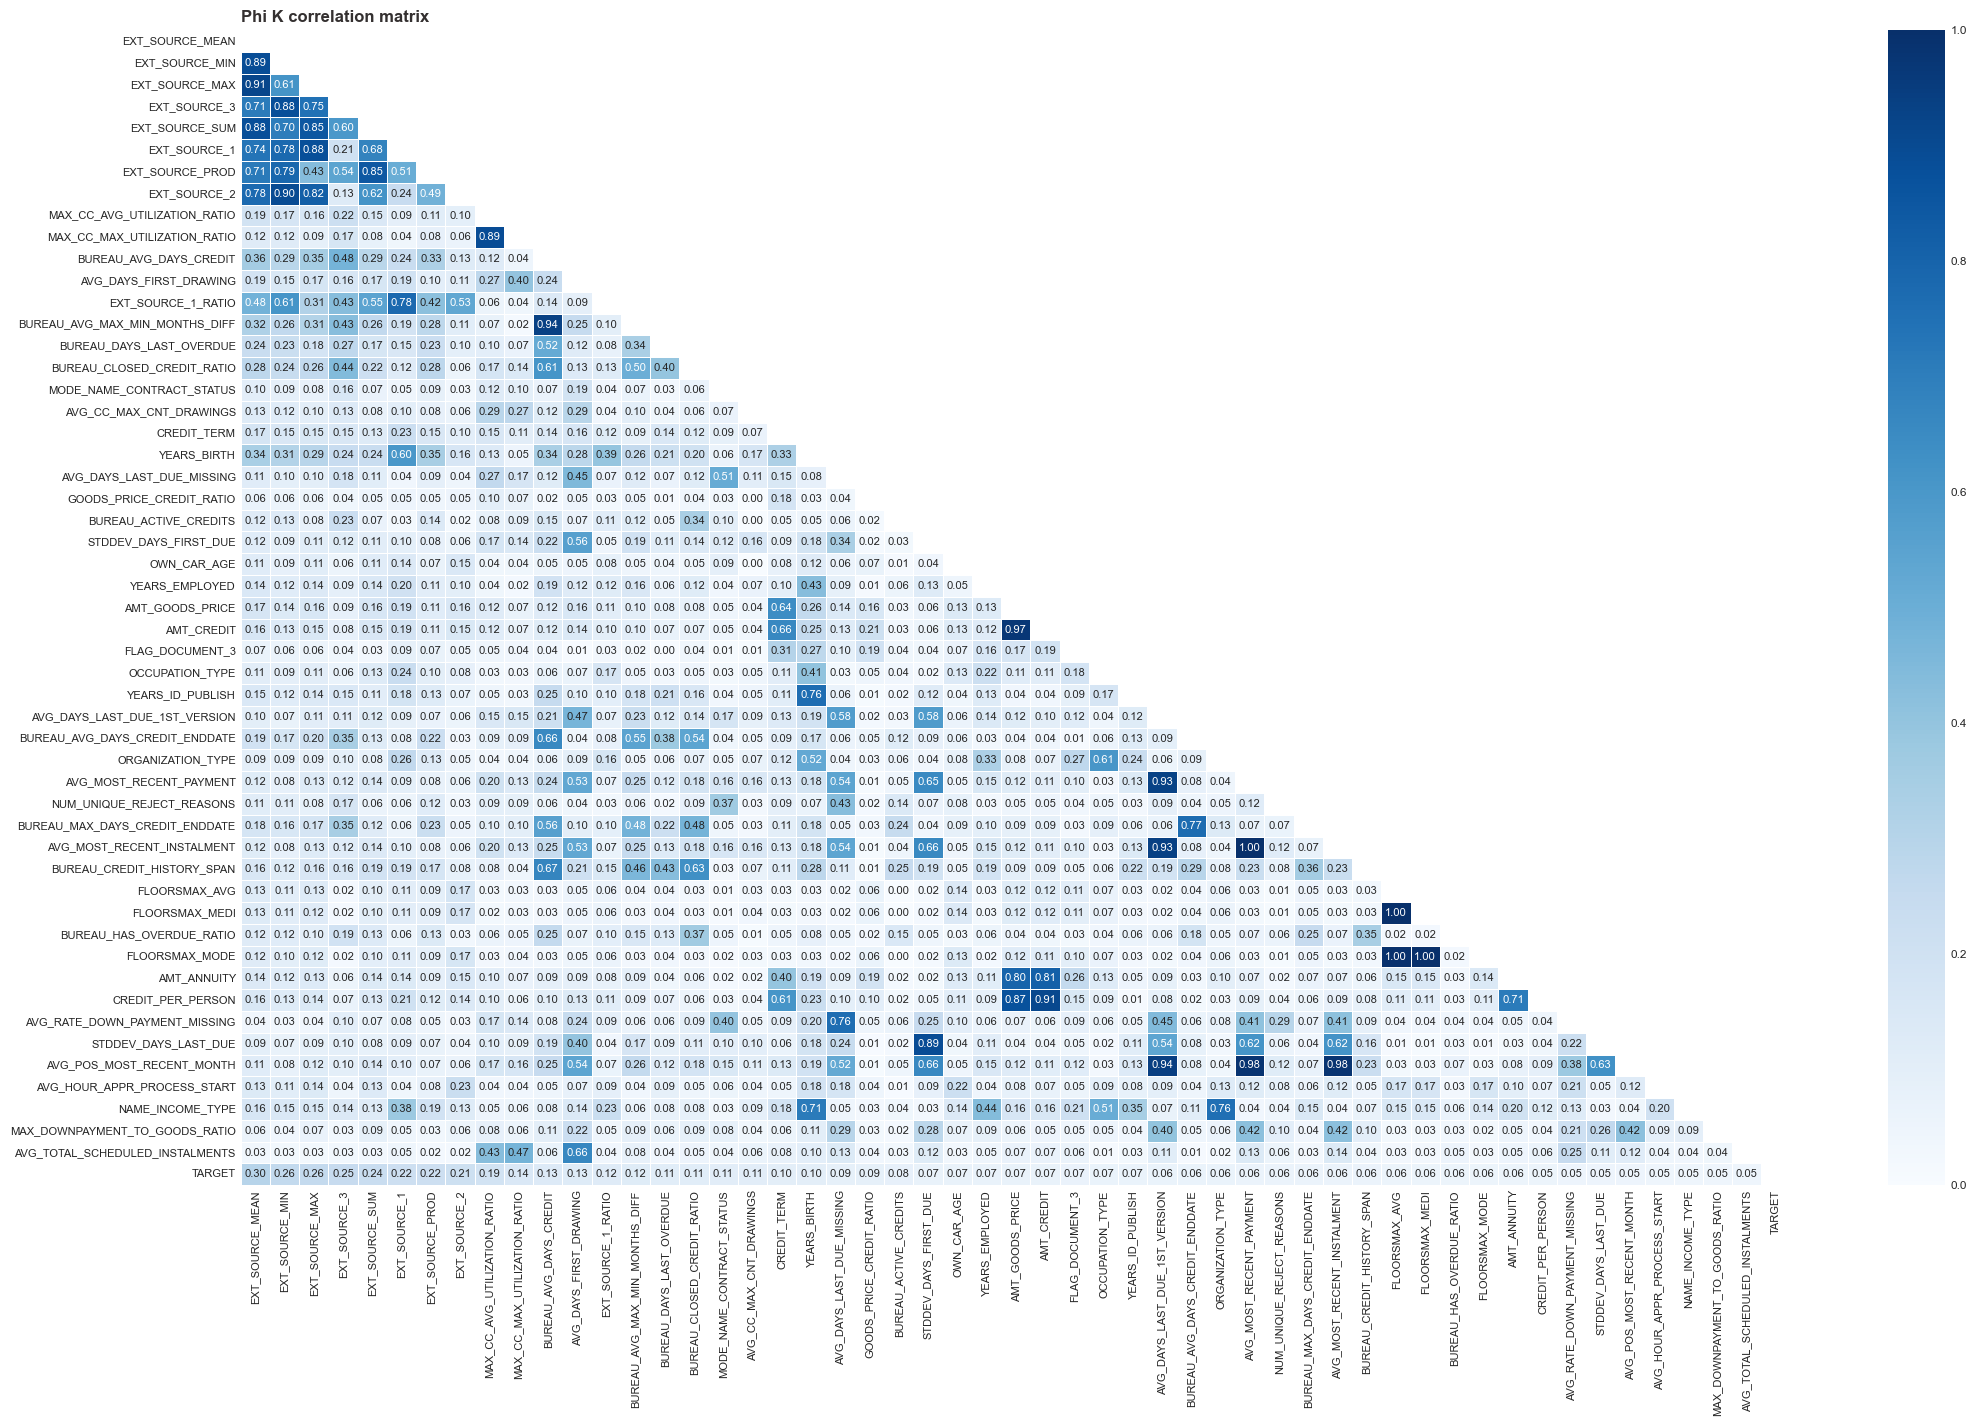

In [176]:
utils.plot_triangle_heatmap(
    phik_df,
    figsize=(25, 15),
    annot_size=8,
    title="Phi K correlation matrix",
    cmap='Blues',
    vmax=1,
    vmin=0,
)

Though we have quite a dense matrix, we can see that strongest correlation with the target is with EXT_SOURCE ratings, and credit card utilization ratios. Below we can see which predictors are most correlated with each other.

In [68]:
very_strong_corr = (phik_df <= 1) & (phik_df >= 0.8)
very_strong_corr_features = utils.find_correlating_pairs(phik_df, very_strong_corr)
very_strong_corr_features

feature_1                       feature_2  correlation
35     AVG_MOST_RECENT_INSTALMENT         AVG_MOST_RECENT_PAYMENT        0.999
37                  FLOORSMAX_AVG                  FLOORSMAX_MEDI        0.999
40                 FLOORSMAX_MEDI                  FLOORSMAX_MODE        0.998
38                  FLOORSMAX_AVG                  FLOORSMAX_MODE        0.995
33        AVG_MOST_RECENT_PAYMENT       AVG_POS_MOST_RECENT_MONTH        0.983
36     AVG_MOST_RECENT_INSTALMENT       AVG_POS_MOST_RECENT_MONTH        0.982
25                     AMT_CREDIT                 AMT_GOODS_PRICE        0.972
30  AVG_DAYS_LAST_DUE_1ST_VERSION       AVG_POS_MOST_RECENT_MONTH        0.945
20         BUREAU_AVG_DAYS_CREDIT  BUREAU_AVG_MAX_MIN_MONTHS_DIFF        0.937
29  AVG_DAYS_LAST_DUE_1ST_VERSION      AVG_MOST_RECENT_INSTALMENT        0.934
28  AVG_DAYS_LAST_DUE_1ST_VERSION         AVG_MOST_RECENT_PAYMENT        0.932
6                  EXT_SOURCE_MAX                 EXT_SOURCE_MEAN        0.914
27                     AMT_CREDIT               CREDIT_PER_PERSON        0.909
16                   EXT_SOURCE_2                  EXT_SOURCE_MIN        0.897
22          STDDEV_DAYS_FIRST_DUE            STDDEV_DAYS_LAST_DUE        0.893
18   MAX_CC_AVG_UTILIZATION_RATIO    MAX_CC_MAX_UTILIZATION_RATIO        0.891
0                 EXT_SOURCE_MEAN                  EXT_SOURCE_MIN        0.888
2                 EXT_SOURCE_MEAN                  EXT_SOURCE_SUM        0.882
14                   EXT_SOURCE_1                  EXT_SOURCE_MAX        0.882
10                   EXT_SOURCE_3                  EXT_SOURCE_MIN        0.882
24                AMT_GOODS_PRICE               CREDIT_PER_PERSON        0.873
7                  EXT_SOURCE_MAX                  EXT_SOURCE_SUM        0.850
15                EXT_SOURCE_PROD                  EXT_SOURCE_SUM        0.845
17                   EXT_SOURCE_2                  EXT_SOURCE_MAX        0.820
43                    AMT_ANNUITY                      AMT_CREDIT        0.813

From the table above we can notice that features related to the different statistics of the same variable (like median, mean, mode, sum, max, min, std) are highly correlated with each other. 

First, we will try to leave only FLOORSMAX_MEDI feature, all three features related to FLOORSMAX have the same correlation score with target, so the choice is arbitrary. For the rest will rely on the regularization of the model to handle multicollinearity, and now will score ROC AUC of the models with cross-validation.

In [69]:
results_bal_v3 = utils.score_models(
    X_train_boruta_lgbm.drop(columns=["FLOORSMAX_MODE", "FLOORSMAX_AVG"]),
    y_train,
    models_bal,
    preprocessor_gbm_v2,
)
results_bal_v3

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7733       0.0026
CatBoostClassifier                    0.7708       0.0025
LGBMClassifier                        0.7691       0.0030
HistGradientBoostingClassifier        0.7682       0.0028

Next, we will additionally drop AVG_POS_MOST_RECENT_MONTH feature that is also very collinear with AVG_MOST_RECENT_INSTALMENT, but the latter has higher correlation with the target.

In [70]:
results_bal_v4 = utils.score_models(
    X_train_boruta_lgbm.drop(
        columns=["FLOORSMAX_MODE", "FLOORSMAX_AVG", "AVG_POS_MOST_RECENT_MONTH"]
    ),
    y_train,
    models_bal,
    preprocessor_gbm_v2,
)
results_bal_v4

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7735       0.0026
CatBoostClassifier                    0.7706       0.0023
LGBMClassifier                        0.7687       0.0028
HistGradientBoostingClassifier        0.7681       0.0028

We can see that eliminating FLOORSMAX_MODE and FLOORSMAX_AVG features improved slightly XGBoost model performance from 0.7732 to 0.7733, for other models the change is negligible. However, removing AVG_POS_MOST_RECENT_MONTH feature decreased slightly performance of all models, except XGBoost. So we will keep this feature for further modeling phase, removing just redundant FLOORSMAX_MODE and FLOORSMAX_AVG features.

Next we will examine selected numerical feature distributions, their relation with the target variable, and statistical significance for the difference in medians performing permutations tests.

We will also drop missingness indicators from the numerical feature list to plot them as categorical features.

In [71]:
numerical_features = (
    df_train.drop(
        columns=[
            "TARGET",
            "FLAG_DOCUMENT_3",
            "AVG_RATE_DOWN_PAYMENT_MISSING",
            "AVG_DAYS_LAST_DUE_MISSING",
            "FLOORSMAX_MODE",
            "FLOORSMAX_AVG",
        ]
    )
    .select_dtypes(include=[np.number])
    .columns.tolist()
)

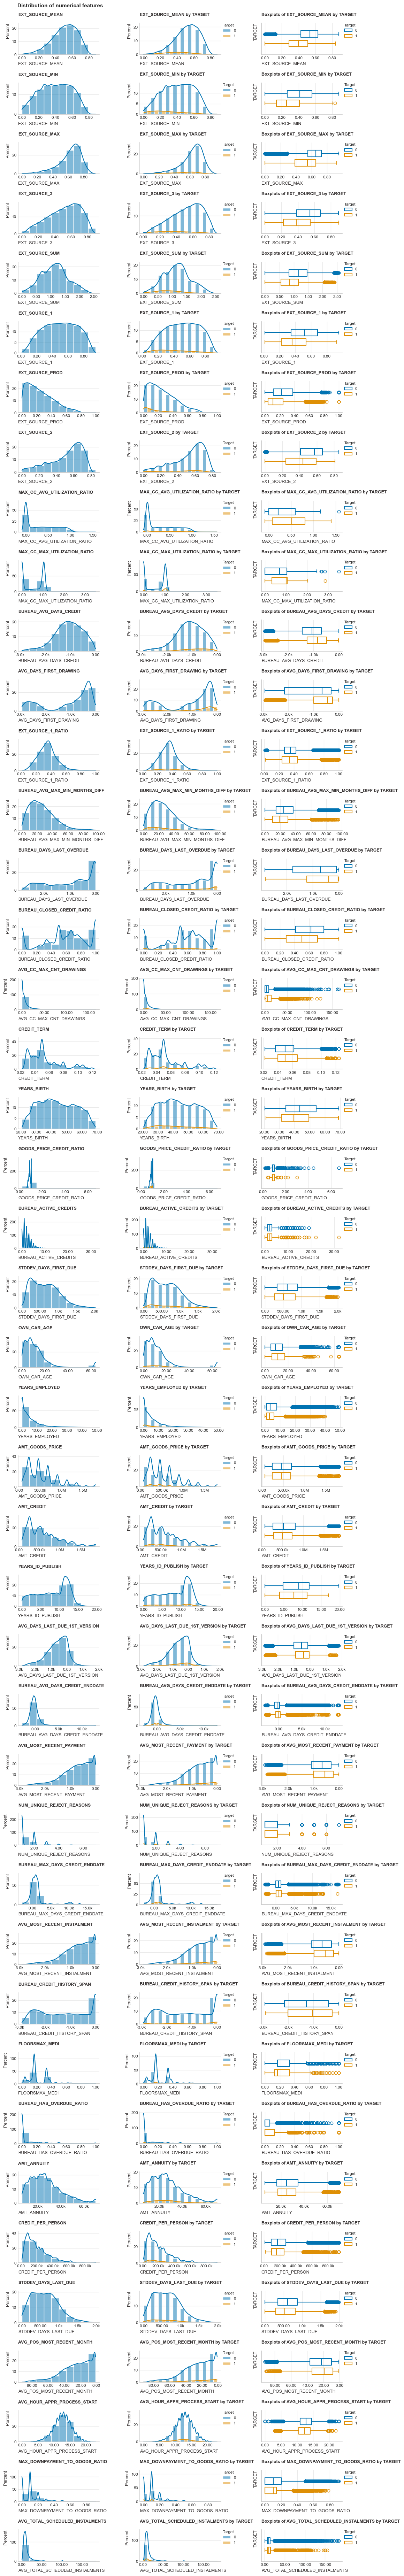

In [184]:
utils.plot_numerical_feature_distribution(
    df_train,
    (12, 2.2 * len(numerical_features)),
    numerical_features,
    "TARGET",
    0.225,
    0.886,
    0.5,
    0.9,
)

From numerical feature distribution overview we see that features related to EXT_SOURCE ratings, credit card utilization ratios, average days from first drawing, years birth, years ID published, bureau closed credit ratio, active credit ratio, average credit days, and days from last overdue payment seem to have significant difference in medians between the two target classes. We will further explore these differences using statistical inference.

For the numerical features we will perform permutation tests to assess the statistical significance of the difference in medians between the two target classes - defaulted and non-defaulted clients. We will also construct 95% confidence intervals for the difference in medians using bootstrap method. So we will formulate the null and alternative hypotheses as follows:
$$
\begin{equation*}
\begin{array}{l}
H_0: \text{There is no difference in the medians of a certain numerical feature between the clients who defaulted and not.} \\
H_A: \text{There is a difference in the medians of a certain numerical feature between the clients who defaulted and not.} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

In [73]:
group_0 = df_train["TARGET"] == 0
group_1 = df_train["TARGET"] == 1

stat_inference_df = pd.DataFrame(data={"Numerical_feat": numerical_features})
for i, col in enumerate(numerical_features):
    p_value = utils.make_stat_permutation_test(
        df_train,
        "TARGET",
        col,
        group_0,
        group_1,
        statistic=np.median,
        replications=4_000,
    )

    stat_inference_df.loc[i, "p_value"] = p_value

    left, right, stat_diff = utils.get_stat_diff_bootstrap_ci(
        df_train,
        "TARGET",
        group_0,
        group_1,
        col,
        statistic=np.median,
        n_bootstrap=4_000,
        alpha=0.05,
    )
    stat_inference_df.loc[i, "Median_diff"] = stat_diff
    stat_inference_df.loc[i, "CI_lower"] = left
    stat_inference_df.loc[i, "CI_upper"] = right

stat_inference_df["Significant"] = stat_inference_df["p_value"] < 0.05
stat_inference_df = stat_inference_df.sort_values(
    by="p_value", ascending=True
).reset_index(drop=True)
with pd.option_context("display.float_format", "{:.2e}".format):
    display(stat_inference_df)

Numerical_feat  p_value  Median_diff  CI_lower  CI_upper  \
0                   EXT_SOURCE_MEAN 0.00e+00    -1.34e-01 -1.37e-01 -1.31e-01   
1                       OWN_CAR_AGE 0.00e+00     2.00e+00  2.00e+00  3.00e+00   
2                    YEARS_EMPLOYED 0.00e+00    -5.42e-01 -6.11e-01 -4.82e-01   
3                        AMT_CREDIT 0.00e+00    -2.33e+04 -2.81e+04 -1.85e+04   
4                  YEARS_ID_PUBLISH 0.00e+00    -1.31e+00 -1.43e+00 -1.21e+00   
5     AVG_DAYS_LAST_DUE_1ST_VERSION 0.00e+00     1.32e+02  1.20e+02  1.45e+02   
6    BUREAU_AVG_DAYS_CREDIT_ENDDATE 0.00e+00     2.01e+02  1.88e+02  2.14e+02   
7           AVG_MOST_RECENT_PAYMENT 0.00e+00     1.12e+02  1.01e+02  1.23e+02   
8    MAX_DOWNPAYMENT_TO_GOODS_RATIO 0.00e+00    -1.00e-05 -1.00e-05 -1.00e-05   
9    BUREAU_MAX_DAYS_CREDIT_ENDDATE 0.00e+00     1.66e+02  1.49e+02  1.83e+02   
10       BUREAU_CREDIT_HISTORY_SPAN 0.00e+00     2.58e+02  2.33e+02  2.81e+02   
11                   FLOORSMAX_MEDI 0.00e+00     0.00e+00  0.00e+00  0.00e+00   
12         BUREAU_HAS_OVERDUE_RATIO 0.00e+00     0.00e+00  0.00e+00  0.00e+00   
13                CREDIT_PER_PERSON 0.00e+00    -1.15e+04 -1.60e+04 -9.59e+03   
14             STDDEV_DAYS_LAST_DUE 0.00e+00    -6.77e+01 -7.86e+01 -5.79e+01   
15        AVG_POS_MOST_RECENT_MONTH 0.00e+00     3.20e+00  3.00e+00  3.75e+00   
16      AVG_HOUR_APPR_PROCESS_START 0.00e+00    -4.00e-01 -4.67e-01 -3.45e-01   
17       AVG_MOST_RECENT_INSTALMENT 0.00e+00     1.11e+02  1.00e+02  1.23e+02   
18            BUREAU_ACTIVE_CREDITS 0.00e+00     0.00e+00  0.00e+00  0.00e+00   
19            STDDEV_DAYS_FIRST_DUE 0.00e+00    -1.04e+02 -1.16e+02 -9.07e+01   
20                      YEARS_BIRTH 0.00e+00    -4.42e+00 -4.67e+00 -4.18e+00   
21                   EXT_SOURCE_MIN 0.00e+00    -1.61e-01 -1.64e-01 -1.57e-01   
22                   EXT_SOURCE_MAX 0.00e+00    -1.09e-01 -1.13e-01 -1.06e-01   
23                     EXT_SOURCE_3 0.00e+00    -1.65e-01 -1.72e-01 -1.60e-01   
24                   EXT_SOURCE_SUM 0.00e+00    -3.19e-01 -3.28e-01 -3.12e-01   
25                     EXT_SOURCE_1 0.00e+00    -1.56e-01 -1.62e-01 -1.48e-01   
26                  EXT_SOURCE_PROD 0.00e+00    -1.16e-01 -1.19e-01 -1.14e-01   
27                     EXT_SOURCE_2 0.00e+00    -1.32e-01 -1.38e-01 -1.27e-01   
28     MAX_CC_AVG_UTILIZATION_RATIO 0.00e+00     2.99e-01  2.83e-01  3.18e-01   
29         GOODS_PRICE_CREDIT_RATIO 0.00e+00    -2.06e-02 -2.06e-02 -2.06e-02   
30     MAX_CC_MAX_UTILIZATION_RATIO 0.00e+00     3.30e-01  3.14e-01  3.46e-01   
31           BUREAU_AVG_DAYS_CREDIT 0.00e+00     2.26e+02  2.15e+02  2.39e+02   
32           AVG_DAYS_FIRST_DRAWING 0.00e+00     2.26e+02  2.03e+02  2.46e+02   
33               EXT_SOURCE_1_RATIO 0.00e+00    -9.74e-03 -1.40e-02 -5.87e-03   
34   BUREAU_AVG_MAX_MIN_MONTHS_DIFF 0.00e+00    -5.74e+00 -6.25e+00 -5.12e+00   
35         BUREAU_DAYS_LAST_OVERDUE 0.00e+00     3.08e+02  2.67e+02  3.39e+02   
36       BUREAU_CLOSED_CREDIT_RATIO 0.00e+00    -1.25e-01 -1.25e-01 -1.25e-01   
37          AVG_CC_MAX_CNT_DRAWINGS 0.00e+00     3.00e+00  2.00e+00  4.00e+00   
38                      AMT_ANNUITY 9.75e-03     3.28e+02  8.10e+01  5.62e+02   
39                  AMT_GOODS_PRICE 1.00e+00     0.00e+00  0.00e+00  0.00e+00   
40                      CREDIT_TERM 1.00e+00     0.00e+00  0.00e+00  0.00e+00   
41        NUM_UNIQUE_REJECT_REASONS 1.00e+00     0.00e+00  0.00e+00  0.00e+00   
42  AVG_TOTAL_SCHEDULED_INSTALMENTS 1.00e+00     0.00e+00  0.00e+00  0.00e+00   

    Significant  
0          True  
1          True  
2          True  
3          True  
4          True  
5          True  
6          True  
7          True  
8          True  
9          True  
10         True  
11         True  
12         True  
13         True  
14         True  
15         True  
16         True  
17         True  
18         True  
19         True  
20         True  
21         True  
22         True  
23         True  
24    

We have got that only NUM_UNIQUE_REJECT_REASONS, AMT_GOODS_PRICE, AVG_TOTAL_SCHEDULED_INSTALMENTS and CREDIT_TERM features do not have statistically significant difference in the medians between the two target classes. The rest of the numerical features have statistically significant difference in medians at alpha=0.05 significance level. However, Boruta SHAP might have selected those features for possibly predictive power increasing interactions with other features.

Below we will plot those differences in medians with 95% confidence intervals for the statistically significant features, grouping them by the magnitude of the difference.

In [74]:
p_signif_mask = stat_inference_df["p_value"] < 0.05

stat_inference_df_low = stat_inference_df[
    p_signif_mask
    & (stat_inference_df["Median_diff"].lt(0))
    & (stat_inference_df["Median_diff"].ge(-1))
].reset_index(drop=True)

stat_inference_df_low_2 = stat_inference_df[
    p_signif_mask
    & (stat_inference_df["Median_diff"].lt(1))
    & (stat_inference_df["Median_diff"].ge(0))
].reset_index(drop=True)

stat_inference_df_med = stat_inference_df[
    p_signif_mask
    & (stat_inference_df["Median_diff"].lt(-1))
    & (stat_inference_df["Median_diff"].ge(-5e1))
].reset_index(drop=True)

stat_inference_df_med_2 = stat_inference_df[
    p_signif_mask
    & (stat_inference_df["Median_diff"].lt(-5e1))
    & (stat_inference_df["Median_diff"].ge(-5e3))
].reset_index(drop=True)

stat_inference_df_med_3 = stat_inference_df[
    p_signif_mask & (stat_inference_df["Median_diff"].le(-5e3))
].reset_index(drop=True)

stat_inference_df_high = stat_inference_df[
    p_signif_mask
    & (stat_inference_df["Median_diff"].gt(1))
    & (stat_inference_df["Median_diff"].le(1e2))
].reset_index(drop=True)

stat_inference_df_high_2 = stat_inference_df[
    p_signif_mask & (stat_inference_df["Median_diff"].gt(1e2))
].reset_index(drop=True)

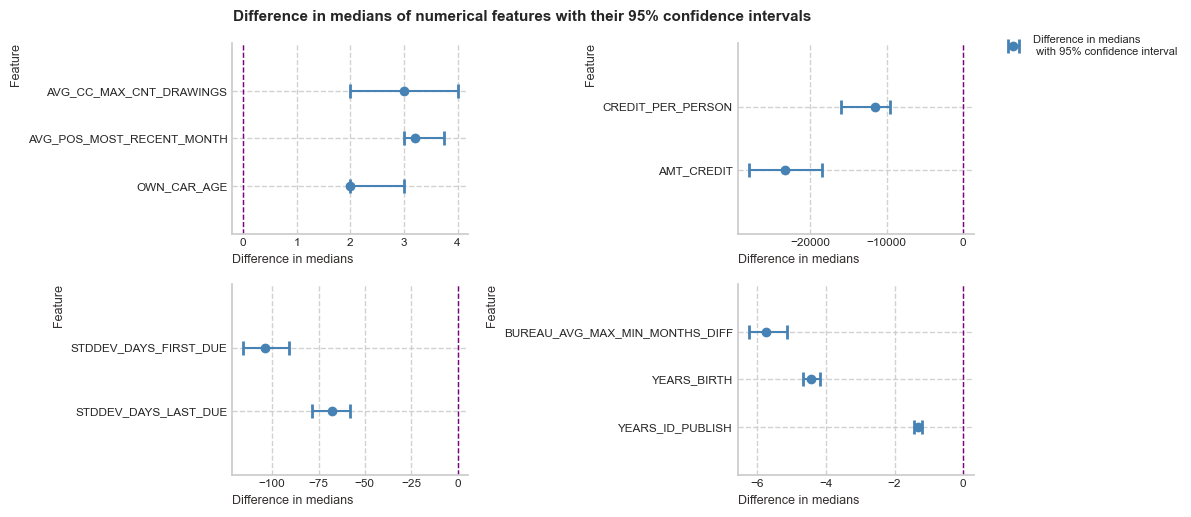

In [197]:
errorbar_list = [
    stat_inference_df_high,
    stat_inference_df_med_3,
    stat_inference_df_med_2,
    stat_inference_df_med,
]

utils.plot_errorbar(
    ci_df=errorbar_list,
    metric="Median_diff",
    feature="Numerical_feat",
    fig_size=(10, 5),
    right=0.53,
    top=1.03,
    nrows=2,
    ncols=2,
)

From the errorbar plots above we see that AMT_CREDIT and CREDIT_PER_PERSON have the highest difference in medians between the two target classes, higher credits and credit per person amount being of those who didn't default. However, credit card maximum count of drawings, car age, average of cash loans (POS) oldest month balance together with average of POS most recent month balance being higher of those who defaulted. Younger persons with more recently published ID seem to have higher risk of default as well. Lower both in standard deviation of previous application first due dates and standard deviation in previous application last due dates also seem to be related with higher risk of default.

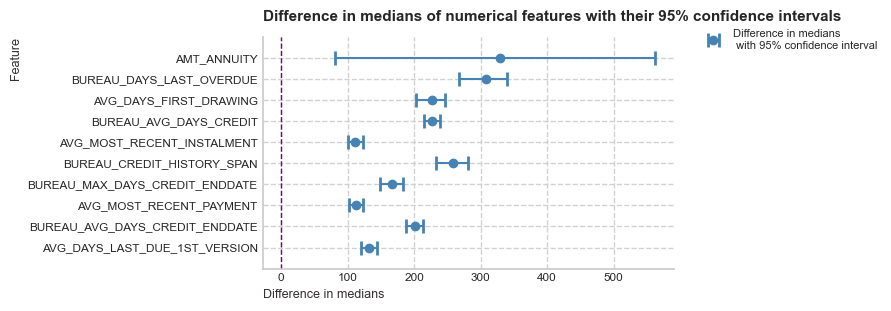

In [196]:
utils.plot_errorbar(
    stat_inference_df_high_2,
    "Median_diff",
    "Numerical_feat",
    (7, 0.3 * len(stat_inference_df_high_2)),
    right=0.8,
    top=1.03,
)

The plot above shows that AMT_ANNUITY is a lot higher for those who defaulted, but this difference has quite a wide confidence interval. Bureau days last overdue seem also to have positive relation with the target variable, higher days last overdue being of those who defaulted.

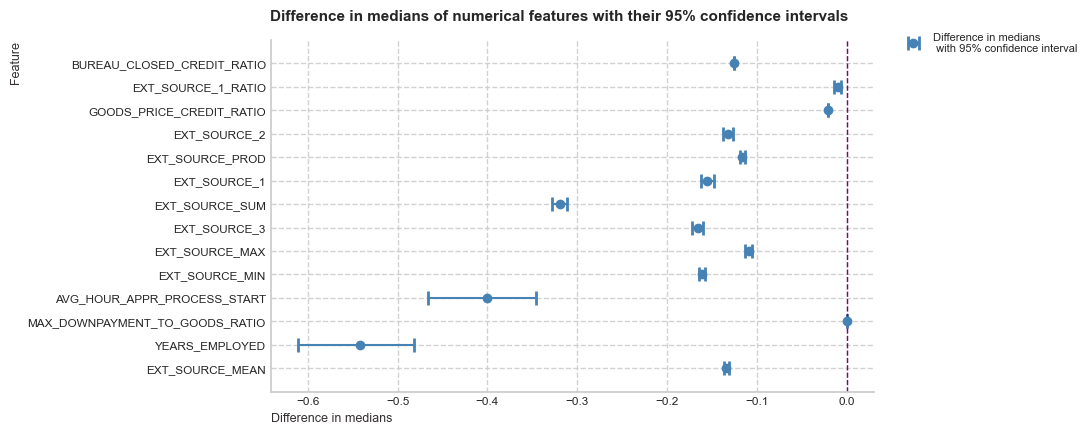

In [195]:
utils.plot_errorbar(
    stat_inference_df_low,
    "Median_diff",
    "Numerical_feat",
    (9, 0.3 * len(stat_inference_df_low)),
    right=0.63,
    top=1.03,
)

The difference in the medians is quite significant for YEARS_EMPLOYED, and AVERAGE_HOUR_APPR_PROCESS_START, higher values being of those who didn't default, but confidence intervals are quite wide comparing with other ratio based features.

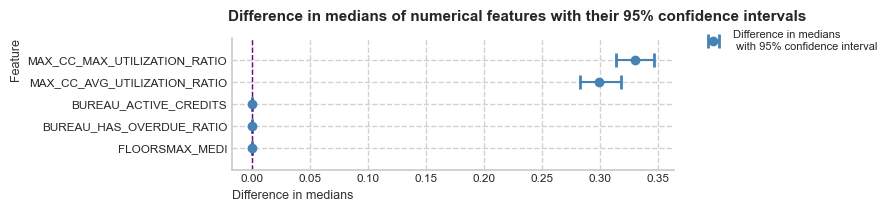

In [202]:
utils.plot_errorbar(
    stat_inference_df_low_2,
    "Median_diff",
    "Numerical_feat",
    (7, 0.4 * len(stat_inference_df_low_2)),
    right=0.75,
    top=1.05,
)

Lastly, credit card utilization ratios tend to be higher for those who defaulted with some fluctuation within CI range.
Below we will plot CI for difference in medians for features which were identified as insignificant in the previous step.

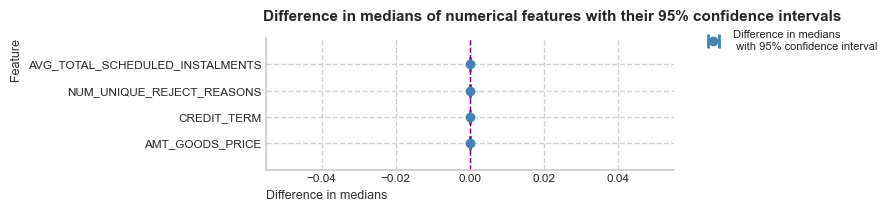

In [207]:
stat_inference_df_insig = stat_inference_df[~p_signif_mask]

utils.plot_errorbar(
    stat_inference_df_insig,
    "Median_diff",
    "Numerical_feat",
    (7, 0.5 * len(stat_inference_df_insig)),
    right=0.8,
    top=1.05,
)

We see that these features have very narrow confidence intervals around zero, confirming that they do not have statistically significant difference in medians between the two target classes.

Further, we will examine categorical feature distributions, their relation with the target variable, and statistical significance for the difference in proportions performing Chi-squared tests.

So we will formulate the null and alternative hypotheses as follows:
$$
\begin{equation*}
\begin{array}{l}
H_0: \text{There is no association between a specific categorical feature and the risk of defaulting.} \\
H_A: \text{There is an association between a specific categorical feature and the risk of defaulting.} \\
\alpha = 0.05
\end{array}
\end{equation*}
$$

In [80]:
cat_features = df_train.select_dtypes(exclude=[np.number]).columns.tolist() + [
    "FLAG_DOCUMENT_3",
    "AVG_RATE_DOWN_PAYMENT_MISSING",
    "AVG_DAYS_LAST_DUE_MISSING",
]

In [81]:
print(f"The lis of categorical features ({len(cat_features)}):")
cat_features

The lis of categorical features (7):


['MODE_NAME_CONTRACT_STATUS',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'NAME_INCOME_TYPE',
 'FLAG_DOCUMENT_3',
 'AVG_RATE_DOWN_PAYMENT_MISSING',
 'AVG_DAYS_LAST_DUE_MISSING']

In [82]:
summary_cat = {}
for col in cat_features:
    p_value = utils.make_chi_test(df_train, "TARGET", col)
    summary_cat[col] = p_value

summary_cat_df = pd.DataFrame.from_dict(
    summary_cat, orient="index", columns=["p_value"]
).sort_values(by="p_value", ascending=True)

summary_cat_df["Significant"] = summary_cat_df["p_value"] < 0.05
summary_cat_df.reset_index(inplace=True)
summary_cat_df.rename(columns={"index": "Categorical_feat"}, inplace=True)
with pd.option_context("display.float_format", "{:.2e}".format):
    display(summary_cat_df)

Categorical_feat  p_value  Significant
0      MODE_NAME_CONTRACT_STATUS 0.00e+00         True
1                OCCUPATION_TYPE 0.00e+00         True
2              ORGANIZATION_TYPE 0.00e+00         True
3               NAME_INCOME_TYPE 0.00e+00         True
4                FLAG_DOCUMENT_3 0.00e+00         True
5  AVG_RATE_DOWN_PAYMENT_MISSING 0.00e+00         True
6      AVG_DAYS_LAST_DUE_MISSING 0.00e+00         True

We can notice that all categorical features have statistically significant association with the target variable at alpha=0.05 significance level.

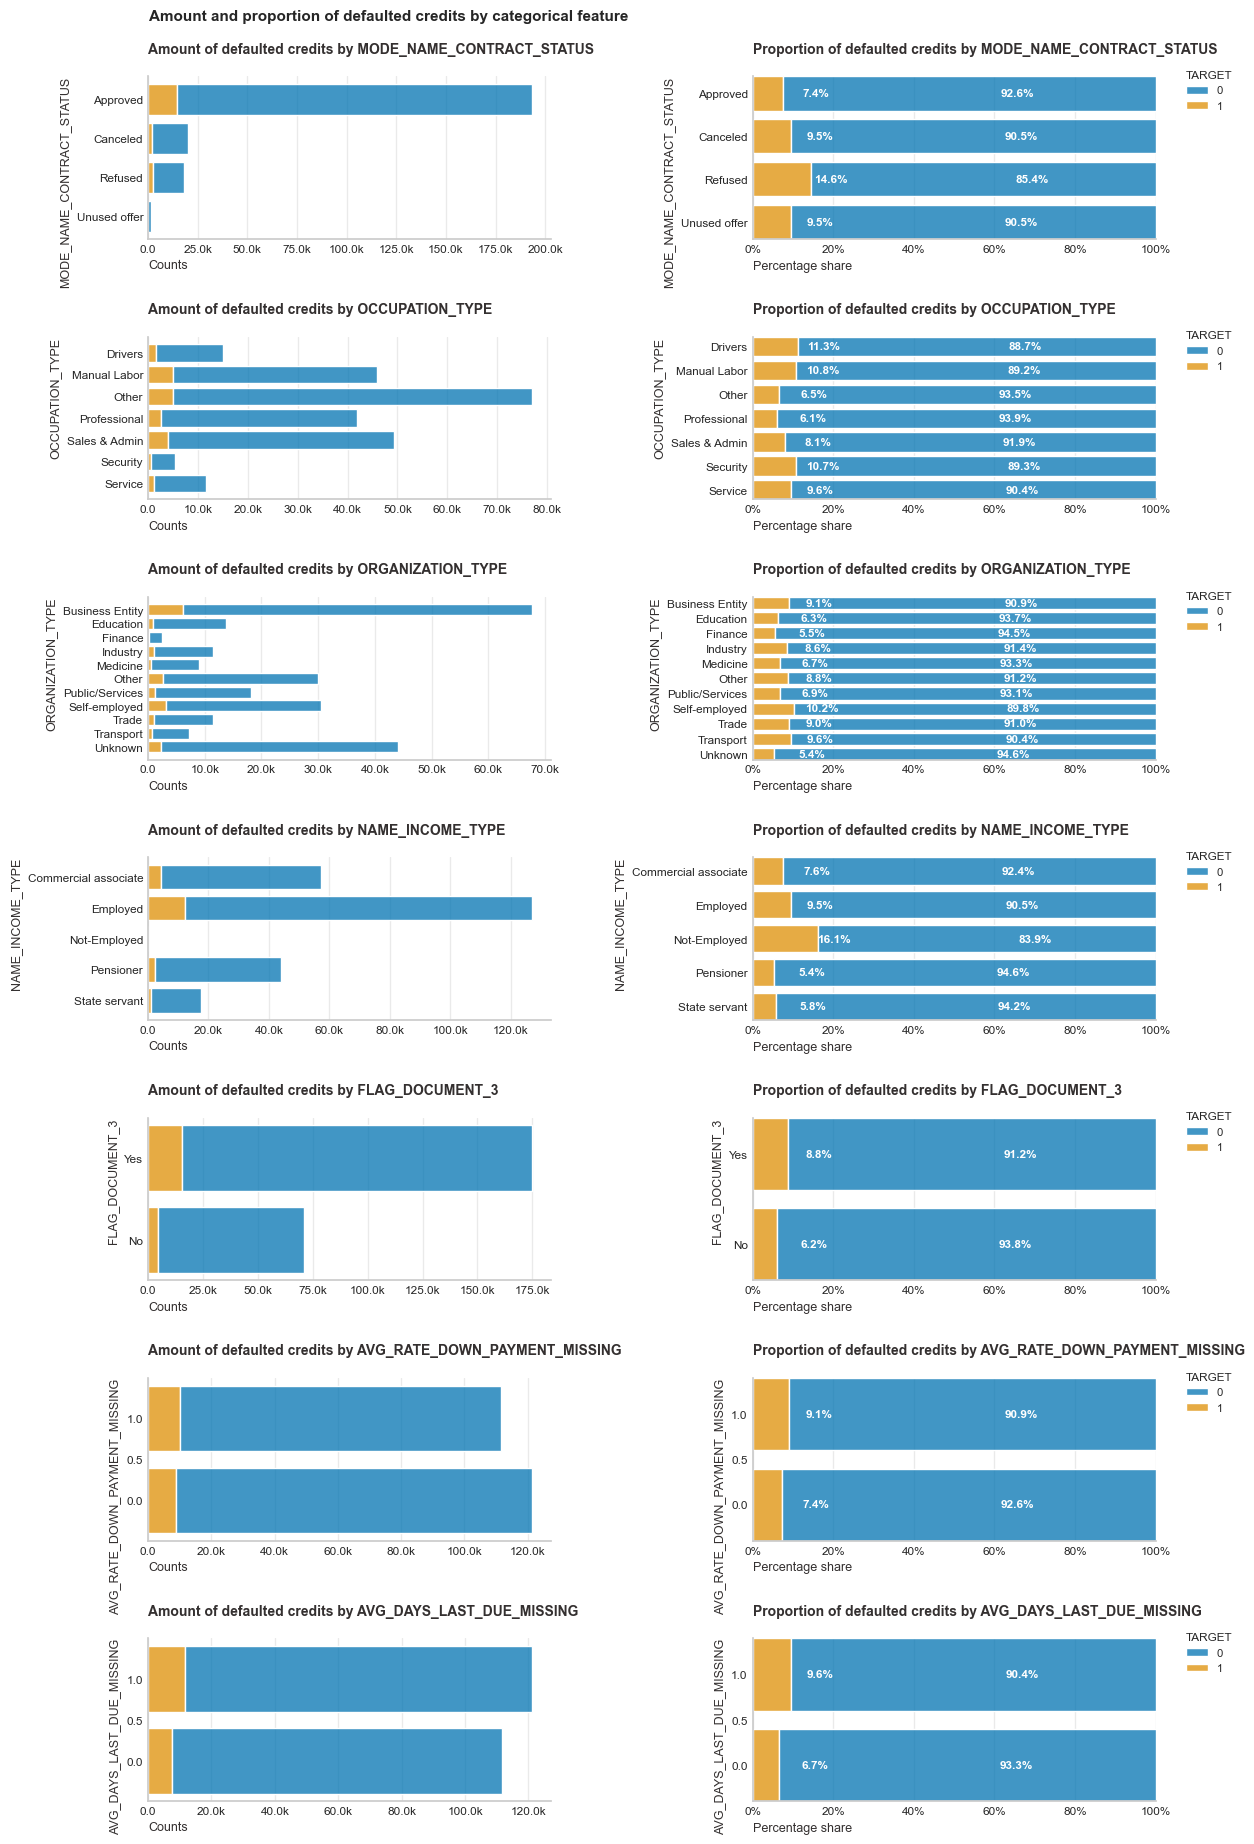

In [214]:
utils.plot_categorical_features(
    df_train,
    "TARGET",
    cat_features,
    (13, 3.2 * len(cat_features)),
    0.91,
    0.31,
    xticks=["No", "Yes"],
    hspace=0.6,
    padding=35,
)

From the plot above we can notice that if the applicant had contract status 'Refused' for the previous application, then one had a higher risk of default. Not-employed or self-employed applicants, working manual labor jobs tend to have higher default rates as well.

Summarizing insights from statistical inference analysis and closer examination of feature distributions we can identify potential feature interactions to engineer for our model and create *Feature Interactions* transformer. Also, we will drop highly multicollinear features related to FLOORSMAX to reduce feature redundancy. More features could be dropped, but we will leave for tuning to decide about the magnitude of the regularization in order to maximize ROC AUC score. 

So next we will score our models again with those interaction features added to the dataset. Additionally, we will re-run Boruta SHAP feature selection to identify the most important interaction features for our model.

After adding *Feature Interactions* transformer to the preprocessing pipeline we will score all the models using cross-validation ROC AUC scores.

In [84]:
feat_inter_scores = utils.score_models(
    X_train_boruta_lgbm, y_train, models_bal, preprocessor_gbm_v2, FeatureInteractions()
)
feat_inter_scores

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7729       0.0024
CatBoostClassifier                    0.7704       0.0028
LGBMClassifier                        0.7678       0.0025
HistGradientBoostingClassifier        0.7676       0.0029

Now we will run Boruta SHAP feature selection again to identify the most important features for our model.

In [85]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor_gbm_v2),
        ("feature_interactions", FeatureInteractions()),
    ]
)

X_train_final_interactions = pipe.fit_transform(X_train_boruta_lgbm, y_train)

boruta_lgbm_v2 = BorutaShap(
    model=lgbm_boruta, importance_measure="shap", classification=True
)
boruta_lgbm_v2.fit(
    X=X_train_final_interactions, y=y_train, random_state=SEED, n_trials=40
)

features_to_remove_lgbm_v2 = boruta_lgbm_v2.features_to_remove

X_train_boruta_lgbm_v2 = X_train_final_interactions.drop(
    columns=features_to_remove_lgbm_v2
)

Warning there are missing values in your data !


  0%|          | 0/40 [00:00<?, ?it/s]

45 attributes confirmed important: ['AVG_TOTAL_SCHEDULED_INSTALMENTS', 'AVG_RATE_DOWN_PAYMENT_MISSING', 'BUREAU_ACTIVE_CREDITS', 'DOC_3_INCOME_TYPE_CONTRACT_STATUS', 'AVG_DAYS_LAST_DUE_1ST_VERSION', 'MAX_CC_MAX_UTILIZATION_RATIO', 'BUREAU_DAYS_LAST_OVERDUE', 'GOODS_PRICE_CREDIT_RATIO', 'AVG_POS_MOST_RECENT_MONTH', 'AVG_DAYS_FIRST_DRAWING', 'AMT_GOODS_PRICE', 'EXT_SOURCE_MAX', 'FLOORSMAX_MEDI', 'AMT_ANNUITY', 'OCCUPATION_TYPE', 'MAX_CC_AVG_UTILIZATION_RATIO', 'AVG_DAYS_LAST_DUE_MISSING', 'AMT_CREDIT', 'ORGANIZATION_OCCUPATION_TYPES', 'EXT_SOURCE_2', 'AVG_HOUR_APPR_PROCESS_START', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'BUREAU_MAX_DAYS_CREDIT_ENDDATE', 'EXT_SOURCE_PROD', 'CREDIT_TERM', 'AVG_CC_MAX_CNT_DRAWINGS', 'YEARS_BIRTH', 'EXT_SOURCE_SUM', 'BUREAU_CLOSED_CREDIT_RATIO', 'STDDEV_DAYS_FIRST_DUE', 'AVG_DAYS_FIRST_DRAWING_EXT_SOURCE_MAX', 'AVG_MOST_RECENT_INSTALMENT', 'OWN_CAR_AGE', 'EXT_SOURCE_MIN', 'YEARS_ID_PUBLISH', 'BUREAU_HAS_OVERDUE_RATIO', 'EXT_SOURCE_1', 'CREDIT_PER_PERSON', 'EXT_SOU

We have got selected 55 features after adding interaction features and re-running Boruta SHAP feature selection. For a *Boruta Feature Interactions* transformer we will keep only those interaction features that were selected by Boruta SHAP.

In [86]:
print("Newly selected features after Boruta-Shap with interactions:")
set(X_train_boruta_lgbm_v2.columns).difference(set(X_train_boruta_lgbm.columns))

Newly selected features after Boruta-Shap with interactions:


{'AVG_DAYS_FIRST_DRAWING_EXT_SOURCE_MAX',
 'CLOSED_CREDIT_EXT_SOURCE_MAX_RATIO',
 'DOC_3_INCOME_TYPE_CONTRACT_STATUS',
 'EXT_SOURCE_1_MEAN_RATIO',
 'MAX_AVG_UTILIZATION_EXT_SOURCE_MAX_RATIO',
 'ORGANIZATION_OCCUPATION_TYPES'}

In [87]:
print("Removed features after Boruta-Shap with interactions:")
set(X_train_boruta_lgbm.columns).difference(set(X_train_boruta_lgbm_v2.columns))

Removed features after Boruta-Shap with interactions:


{'FLAG_DOCUMENT_3', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE'}

In [88]:
print(
    "Feature from the original training dataset still present after Boruta-Shap with interactions:"
)
set(X_train_boruta_lgbm_v2.columns).intersection(set(X_train.columns))

Feature from the original training dataset still present after Boruta-Shap with interactions:


{'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_MEDI',
 'NAME_INCOME_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'OWN_CAR_AGE'}

We will run the models again with the updated preprocessing pipeline including *Boruta Feature Interactions* transformer and check their performance using cross-validation ROC AUC scores.

In [89]:
feat_inter_boruta_scores = utils.score_models(
    X_train_boruta_lgbm,
    y_train,
    models_bal,
    preprocessor_gbm_v2,
    FeatureInteractionsBoruta(),
)
feat_inter_boruta_scores

Mean ROC AUC  STD ROC AUC
XGBClassifier                         0.7730       0.0025
CatBoostClassifier                    0.7707       0.0025
LGBMClassifier                        0.7685       0.0030
HistGradientBoostingClassifier        0.7679       0.0030

Now we will get all the scores of our experiments in one place to compare them easily, and select the best preprocessing pipeline for further model tuning phase.

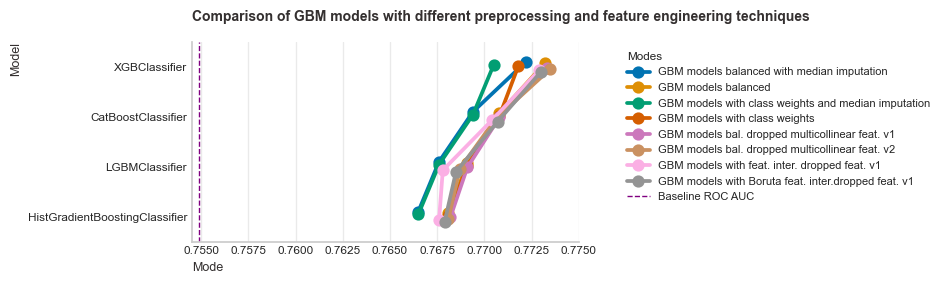

Model                                                CatBoostClassifier  \
Mode                                                                      
GBM models bal. dropped multicollinear feat. v1                  0.7708   
GBM models bal. dropped multicollinear feat. v2                  0.7706   
GBM models balanced                                              0.7708   
GBM models balanced with median imputation                       0.7694   
GBM models with Boruta feat. inter.dropped feat. v1              0.7707   
GBM models with class weights                                    0.7708   
GBM models with class weights and median imputation              0.7694   
GBM models with feat. inter. dropped feat. v1                    0.7704   

Model                                                HistGradientBoostingClassifier  \
Mode                                                                                  
GBM models bal. dropped multicollinear feat. v1                              0.7682   
GBM models bal. dropped multicollinear feat. v2                              0.7681   
GBM models balanced                                                          0.7681   
GBM models balanced with median imputation                                   0.7665   
GBM models with Boruta feat. inter.dropped feat. v1                          0.7679   
GBM models with class weights                                                0.7681   
GBM models with class weights and median imputation                          0.7665   
GBM models with feat. inter. dropped feat. v1                                0.7676   

Model                                                LGBMClassifier  \
Mode                                                                  
GBM models bal. dropped multicollinear feat. v1              0.7691   
GBM models bal. dropped multicollinear feat. v2              0.7687   
GBM models balanced                                          0.7691   
GBM models balanced with median imputation                   0.7676   
GBM models with Boruta feat. inter.dropped feat. v1          0.7685   
GBM models with class weights                                0.7691   
GBM models with class weights and median imputation          0.7676   
GBM models with feat. inter. dropped feat. v1                0.7678   

Model                                                XGBClassifier  
Mode                                                                
GBM models bal. dropped multicollinear feat. v1             0.7733  
GBM models bal. dropped multicollinear feat. v2             0.7735  
GBM models balanced                                         0.7732  
GBM models balanced with median imputation                  0.7722  
GBM models with Boruta feat. inter.dropped feat. v1         0.7730  
GBM models with class weights                               0.7718  
GBM models with class weights and median imputation         0.7705  
GBM models with feat. inter. dropped feat. v1               0.7729

In [90]:
interim_results = [
    results_bal_v1,
    results_bal_v2,
    results_weight_v1,
    results_weights_v2,
    results_bal_v3,
    results_bal_v4,
    feat_inter_scores,
    feat_inter_boruta_scores,
]

mode_names = [
    "GBM models balanced with median imputation",
    "GBM models balanced",
    "GBM models with class weights and median imputation",
    "GBM models with class weights",
    "GBM models bal. dropped multicollinear feat. v1",
    "GBM models bal. dropped multicollinear feat. v2",
    "GBM models with feat. inter. dropped feat. v1",
    "GBM models with Boruta feat. inter.dropped feat. v1",
]

utils.display_model_comparison(
    interim_results,
    mode_names,
    (10, 3),
    "Comparison of GBM models with different preprocessing and feature engineering techniques",
    (0.7545, 0.775),
    baseline_score,
)

We can cee that XGBoost model has the highest learning performance with ROC AUC score of 0.7735 on the validation set using cross-validation. Adding Boruta selected feature interactions improved slightly performance of all models than just adding a bunch of feature interactions. Since pointplots of different experiments overlap a lot, we will test XGBoost model generalization performance on the holdout set with Boruta feature interactions and after just dropping multicollinear features.

In [91]:
drop_feat_v1 = list(all_var_dropped) + list(features_to_remove_lgbm) + ["SK_ID_CURR"]

xgb_pipe_v1 = Pipeline(
    steps=[
        ("feat_clean_pipe", feat_clean_pipe),
        ("table_merger", TableMerger(tables=table_dict)),
        ("feature_dropper", FeatureDropper(features_to_drop=drop_feat_v1)),
        ("categorical_converter", CategoricalConverter(verbose=False)),
        ("preprocessor", preprocessor_gbm_v2),
        ("feature_interactions", FeatureInteractionsBoruta()),
        ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ("classifier", model_xgb),
    ]
)

xgb_pipe_v1.fit(X_train, y_train)

y_pred_proba = xgb_pipe_v1.predict_proba(X_test)[:, 1]
score_v1 = round(roc_auc_score(y_test, y_pred_proba), 4)
print(f"ROC AUC score of the XGBoost model on the test set: {score_v1}")

ROC AUC score of the XGBoost model on the test set: 0.7777


In [92]:
drop_feat_v2 = (
    list(all_var_dropped)
    + list(features_to_remove_lgbm)
    + ["SK_ID_CURR", "FLOORSMAX_MODE", "FLOORSMAX_AVG"]
)

xgb_pipe_v2 = Pipeline(
    steps=[
        ("feat_clean_pipe", feat_clean_pipe),
        ("table_merger", TableMerger(tables=table_dict)),
        ("feature_dropper", FeatureDropper(features_to_drop=drop_feat_v2)),
        ("categorical_converter", CategoricalConverter(verbose=False)),
        ("preprocessor", preprocessor_gbm_v2),
        ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ("classifier", model_xgb),
    ]
)

xgb_pipe_v2.fit(X_train, y_train)

y_pred_proba = xgb_pipe_v2.predict_proba(X_test)[:, 1]
score_v2 = round(roc_auc_score(y_test, y_pred_proba), 4)

print(f"ROC AUC score of the XGBoost model on the test set: {score_v2}")

ROC AUC score of the XGBoost model on the test set: 0.7768


We can see that XGBoost model achieved ROC AUC score of 0.7768 on the holdout set after dropping multicollinear features, and 0.7777 with Boruta selected feature interactions. So we will keep feature interactions for further modeling phase.

Next we will build the final pipeline and fit it to the train subset.

In [ ]:
drop_feat = list(all_var_dropped) + list(features_to_remove_lgbm) + ["SK_ID_CURR"]

final_pipe = Pipeline(
    steps=[
        ("feat_clean_pipe", feat_clean_pipe),
        ("table_merger", TableMerger(tables=table_dict)),
        ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
        ("categorical_converter", CategoricalConverter(verbose=False)),
        ("preprocessor", preprocessor_gbm_v2),
        ("feature_interactions", FeatureInteractionsBoruta()),
        ("numeric_downcaster", NumericDowncaster(verbose=False)),
    ]
)

X_prep_modelling = final_pipe.fit_transform(X_train, y_train)

Below we can see the whole data preprocessing pipeline - from raw data to final modeling dataset with interaction features added.

In [95]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('feat_clean_pipe',
                 Pipeline(steps=[('imputer',
                                  CustomImputer(zero_cols=['OBS_30_CNT_SOCIAL_CIRCLE',
                                                           'DEF_30_CNT_SOCIAL_CIRCLE',
                                                           'OBS_60_CNT_SOCIAL_CIRCLE',
                                                           'DEF_60_CNT_SOCIAL_CIRCLE'])),
                                 ('feature_dropper',
                                  FeatureDropper(features_to_drop=['CODE_GENDER',
                                                                   'FLAG_MOBIL'])),
                                 ('categorical_aggregator',
                                  CategoricalAggregator(mappings={'NAME_EDUCAT...
                ('categorical_converter', CategoricalConverter(verbose=False)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', CatBoostEncoder(),
                                                  ['MODE_NAME_CONTRACT_STATUS',
                                                   'OCCUPATION_TYPE',
                                                   'ORGANIZATION_TYPE',
                                                   'NAME_INCOME_TYPE'])],
                                   verbose_feature_names_out=False)),
                ('feature_interactions', FeatureInteractionsBoruta()),
                ('numeric_downcaster', NumericDowncaster(verbose=False))])

The final feature set already preprocessed together with data types optimized consists of 55 features.

In [96]:
X_prep_modelling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246008 entries, 181648 to 285162
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   MODE_NAME_CONTRACT_STATUS                 246008 non-null  float32
 1   OCCUPATION_TYPE                           246008 non-null  float32
 2   ORGANIZATION_TYPE                         246008 non-null  float32
 3   NAME_INCOME_TYPE                          246008 non-null  float32
 4   AMT_CREDIT                                246008 non-null  float32
 5   AMT_ANNUITY                               245998 non-null  float32
 6   AMT_GOODS_PRICE                           245787 non-null  float32
 7   OWN_CAR_AGE                               83590 non-null   float32
 8   EXT_SOURCE_1                              107413 non-null  float32
 9   EXT_SOURCE_2                              245477 non-null  float32
 10  EXT_SOURCE_3        

#### **Tuning the Models** ####

##### **Tuning LightGBM Model** #####

Before tuning the models let's reimport the dataset again, make train and test splits to ensure that data leakage is avoided, and the tuning is done properly.

Also let's remember initial feature cleaning pipeline which will be used in the modeling phase.

In [97]:
pd.set_option("display.float_format", None)
import xgboost as xg

In [98]:
application_df = pd.read_parquet("../data/application_train.parquet")
y = application_df.pop("TARGET")
X = application_df
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [99]:
cols_to_cap = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "CNT_CHILDREN",
    "CNT_FAM_MEMBERS",
    "OWN_CAR_AGE",
]

feat_clean_pipe = Pipeline(
    steps=[
        (
            "imputer",
            CustomImputer(
                zero_cols=[
                    "OBS_30_CNT_SOCIAL_CIRCLE",
                    "DEF_30_CNT_SOCIAL_CIRCLE",
                    "OBS_60_CNT_SOCIAL_CIRCLE",
                    "DEF_60_CNT_SOCIAL_CIRCLE",
                ],
                add_missing_flags=True,
            ),
        ),
        (
            "feature_dropper",
            FeatureDropper(features_to_drop=["CODE_GENDER", "FLAG_MOBIL"]),
        ),
        ("categorical_aggregator", CategoricalAggregator(mappings=mappings)),
        (
            "outlier_skew_transformer",
            OutlierSkewTransformer(
                columns=cols_to_cap, verbose=False, log_transform=False
            ),
        ),
        ("new_feature_engineering", NewFeatureEngineer()),
        ("days_to_years_transformer", DaysToYearsTransformer()),
    ]
)

In [100]:
cachedir = tempfile.mkdtemp()
memory = Memory(location=cachedir, verbose=0)

inner_splits = 3

Now we will tune hyperparameters of all four models: LightGBM, XGBoost, CatBoost, and HistGradientBoosting using Optuna library with Bayesian optimization approach.

The best hyperparameters will be used to train the final models and compare their performance on the test set. Also we will save the tuned hyperparameters for future reference.

In [101]:
def objective(trial, X_train, y_train, inner_splits=inner_splits):
    params = {
        "objective": "binary",
        "metric": "auc",
        "is_unbalance": True,
        "random_state": SEED,
        "verbosity": -1,
        "bagging_seed": SEED,
        "feature_fraction_seed": SEED,
        "n_estimators": 2_000,
        "num_leaves": trial.suggest_int("num_leaves", 130, 250),
        "max_depth": trial.suggest_int("max_depth", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 15, 40),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.9),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "max_bin": trial.suggest_int("max_bin", 200, 350),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 1e-2, log=True),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.1),
    }

    skf = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=SEED)
    scores, best_iters = [], []

    final_pipe = Pipeline(
        steps=[
            ("feat_clean_pipe", feat_clean_pipe),
            ("table_merger", TableMerger(tables=table_dict)),
            ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
            ("categorical_converter", CategoricalConverter(verbose=False)),
            ("preprocessor", preprocessor_gbm_v2),
            ("feature_interactions", FeatureInteractionsBoruta()),
            ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ],
        memory=memory,
    )

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr_pre = final_pipe.fit_transform(X_tr, y_tr)
        X_val_pre = final_pipe.transform(X_val)

        clf = LGBMClassifier(**params, n_jobs=-1)
        clf.fit(
            X_tr_pre,
            y_tr,
            eval_set=[(X_val_pre, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=25, verbose=False),
            ],
        )

        y_val_proba = clf.predict_proba(X_val_pre)[:, 1]
        scores.append(roc_auc_score(y_val, y_val_proba))
        best_iters.append(clf.best_iteration_)

    trial.set_user_attr("best_iteration", int(np.mean(best_iters)))
    return np.mean(scores)


study = optuna.create_study(
    direction="maximize",
    study_name="LGBM_tuning",
    storage="sqlite:///lgbm_tuning_study.db",
    load_if_exists=True,
    pruner=HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(
        seed=SEED, multivariate=True, n_startup_trials=20
    ),
)

study.optimize(
    lambda trial: objective(trial, X_train, y_train),
    n_trials=60,
    show_progress_bar=True,
    n_jobs=1,
)

best_params_lgbm = study.best_params
best_iteration_lgbm = study.best_trial.user_attrs["best_iteration"]
print(f"Best LGBM hyperparameters:\n{best_params_lgbm}")
print(f"Best LGBM n_estimators:\n{best_iteration_lgbm}")
shutil.rmtree(cachedir)

  0%|          | 0/60 [00:00<?, ?it/s]

Best LGBM hyperparameters:
{'num_leaves': 202, 'max_depth': 3, 'min_child_samples': 23, 'colsample_bytree': 0.5980231299841569, 'learning_rate': 0.0261990892528045, 'max_bin': 312, 'reg_alpha': 0.009177945867327217, 'reg_lambda': 0.003323029595722597, 'subsample_freq': 1, 'subsample': 0.8391989930641014, 'min_split_gain': 0.013329172551181056}
Best LGBM n_estimators:
1719


In [102]:
os.makedirs("model_params", exist_ok=True)

best_params_lgbm["n_estimators"] = best_iteration_lgbm

joblib.dump(best_params_lgbm, "model_params/best_lgbm_params_v4.pkl")
best_params_lgbm = joblib.load("model_params/best_lgbm_params_v4.pkl")

In [105]:
def objective(trial, X_train, y_train, inner_splits=inner_splits):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_delta_step": 1,
        "scale_pos_weight": scaling_balance,
        "random_state": SEED,
        "verbosity": 0,
        "n_estimators": 2_000,
        "early_stopping_rounds": 25,
        "tree_method": "hist",
        "grow_policy": "lossguide",
        "boosting_type": "gbtree",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 2e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 7),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 7, 18, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 30, 50),
        "gamma": trial.suggest_float("gamma", 1.5, 4.5),
    }

    skf = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=SEED)
    scores, best_iters = [], []

    final_pipe = Pipeline(
        steps=[
            ("feat_clean_pipe", feat_clean_pipe),
            ("table_merger", TableMerger(tables=table_dict)),
            ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
            ("categorical_converter", CategoricalConverter(verbose=False)),
            ("preprocessor", preprocessor_gbm_v2),
            ("feature_interactions", FeatureInteractionsBoruta()),
            ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ],
        memory=memory,
    )

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr_pre = final_pipe.fit_transform(X_tr, y_tr)
        X_val_pre = final_pipe.transform(X_val)

        clf = xg.XGBClassifier(**params, n_jobs=-1)
        clf.fit(
            X_tr_pre,
            y_tr,
            eval_set=[(X_val_pre, y_val)],
            verbose=False,
        )

        y_val_proba = clf.predict_proba(X_val_pre)[:, 1]
        scores.append(roc_auc_score(y_val, y_val_proba))
        best_iters.append(clf.best_iteration)

    trial.set_user_attr("best_iteration", int(np.mean(best_iters)))
    return np.mean(scores)


study = optuna.create_study(
    direction="maximize",
    study_name="XGBoost_tuning",
    storage="sqlite:///xgb_tuning_study.db",
    load_if_exists=True,
    pruner=HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(
        seed=SEED, multivariate=True, n_startup_trials=20
    ),
)

study.optimize(
    lambda trial: objective(trial, X_train, y_train),
    n_trials=60,
    show_progress_bar=True,
    n_jobs=1,
)

best_params_xgb = study.best_params
best_iteration_xgb = study.best_trial.user_attrs["best_iteration"]
print(f"Best XGBoost hyperparameters:\n{best_params_xgb}")
print(f"Best XGBoost n_estimators:\n{best_iteration_xgb}")
shutil.rmtree(cachedir)

  0%|          | 0/60 [00:00<?, ?it/s]

Best XGBoost hyperparameters:
{'learning_rate': 0.042074664281129354, 'max_depth': 3, 'subsample': 0.5729532533439395, 'colsample_bytree': 0.8617951318771434, 'colsample_bylevel': 0.7139634250909087, 'reg_alpha': 0.08824601195701193, 'reg_lambda': 13.043852053605374, 'min_child_weight': 40.54694460874869, 'gamma': 2.613239340401714}
Best XGBoost n_estimators:
1161


In [106]:
import json

best_params_xgb["n_estimators"] = best_iteration_xgb

with open("model_params/best_params_xgb_v4.json", "w") as f:
    json.dump(best_params_xgb, f, indent=4)

with open("model_params/best_params_xgb_v4.json", "r") as f:
    best_params_xgb = json.load(f)

In [111]:
def objective(trial, X_train, y_train, inner_splits=inner_splits):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "auto_class_weights": "Balanced",
        "random_seed": SEED,
        "silent": True,
        "iterations": 2_000,
        "depth": trial.suggest_int("depth", 8, 16),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 2e-1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 12.0, 25.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.3, 0.7),
        "random_strength": trial.suggest_float("random_strength", 0.4, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 170),
        "rsm": trial.suggest_float("rsm", 0.6, 1.0),
        "border_count": trial.suggest_int("border_count", 180, 255),
        "grow_policy": "Lossguide",
        "use_best_model": True,
        "od_wait": 25,
        "od_type": "Iter",
    }

    skf = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=SEED)
    scores, best_iters = [], []

    final_pipe = Pipeline(steps=[
            ("feat_clean_pipe", feat_clean_pipe),
            ("table_merger", TableMerger(tables=table_dict)),
            ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
            ("categorical_converter", CategoricalConverter(verbose=False)),
            ("preprocessor", preprocessor_gbm_v2),
            ("feature_interactions", FeatureInteractionsBoruta()),
            ("numeric_downcaster", NumericDowncaster(verbose=False)),
            ], memory=memory)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr_pre = final_pipe.fit_transform(X_tr, y_tr)
        X_val_pre = final_pipe.transform(X_val)

        clf = CatBoostClassifier(**params)
        clf.fit(
            X_tr_pre,
            y_tr,
            eval_set=[(X_val_pre, y_val)],
            verbose=False,
        )

        y_val_proba = clf.predict_proba(X_val_pre)[:, 1]
        scores.append(roc_auc_score(y_val, y_val_proba))
        best_iters.append(clf.get_best_iteration())

    trial.set_user_attr("best_iteration", int(np.mean(best_iters)))
    return np.mean(scores)

study = optuna.create_study(
    direction="maximize",
    study_name="CatBoost_tuning",
    storage="sqlite:///catb_tuning_study.db",
    load_if_exists=True,
    pruner=HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(seed=SEED, multivariate=True, n_startup_trials=20),
)

study.optimize(
    lambda trial: objective(trial, X_train, y_train),
    n_trials=60,
    show_progress_bar=True,
    n_jobs=1,
)

best_params_catb = study.best_params
best_iteration_catb = study.best_trial.user_attrs["best_iteration"]
print(f"Best CatBoost hyperparameters:\n{best_params_catb}")
print(f"Best CatBoost number of iterations:\n{best_iteration_catb}")
shutil.rmtree(cachedir)

  0%|          | 0/60 [00:00<?, ?it/s]

Best CatBoost hyperparameters:
{'depth': 14, 'learning_rate': 0.01029755305092623, 'l2_leaf_reg': 18.09117831335883, 'bagging_temperature': 0.538121380326021, 'random_strength': 0.6579802373263367, 'min_data_in_leaf': 164, 'rsm': 0.8173893326490466, 'border_count': 255}
Best CatBoost number of iterations:
1856


In [113]:
best_params_catb["iterations"] = best_iteration_catb

joblib.dump(best_params_catb, "model_params/best_catb_params_v4.pkl")
best_params_catb = joblib.load("model_params/best_catb_params_v4.pkl")

In [108]:
def objective(trial, X_train, y_train, inner_splits=inner_splits):
    params = {
        "loss": "log_loss",
        "class_weight": "balanced",
        "early_stopping": True,
        "random_state": SEED,
        "max_iter": 1_500,
        "verbose": 0,
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 4, 32),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 2e-1, log=True),
        "l2_regularization": trial.suggest_float(
            "l2_regularization", 1e-10, 1e-5, log=True
        ),
        "max_bins": trial.suggest_int("max_bins", 150, 255),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 80, 180),
        "n_iter_no_change": 25,
        "validation_fraction": 0.1,
    }

    skf = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=SEED)
    scores, best_iters = [], []

    final_pipe = Pipeline(
        steps=[
            ("feat_clean_pipe", feat_clean_pipe),
            ("table_merger", TableMerger(tables=table_dict)),
            ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
            ("categorical_converter", CategoricalConverter(verbose=False)),
            ("preprocessor", preprocessor_gbm_v2),
            ("feature_interactions", FeatureInteractionsBoruta()),
            ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ],
        memory=memory,
    )

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_tr_pre = final_pipe.fit_transform(X_tr, y_tr)
        X_val_pre = final_pipe.transform(X_val)

        clf = HistGradientBoostingClassifier(**params)
        clf.fit(X_tr_pre, y_tr)

        y_val_proba = clf.predict_proba(X_val_pre)[:, 1]
        scores.append(roc_auc_score(y_val, y_val_proba))
        best_iters.append(clf.n_iter_)

    trial.set_user_attr("best_iteration", int(np.mean(best_iters)))
    return np.mean(scores)


study = optuna.create_study(
    direction="maximize",
    study_name="HGBoost_tuning",
    storage="sqlite:///hgb_tuning_study.db",
    load_if_exists=True,
    pruner=HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(
        seed=SEED, multivariate=True, n_startup_trials=20
    ),
)

study.optimize(
    lambda trial: objective(trial, X_train, y_train),
    n_trials=60,
    show_progress_bar=True,
    n_jobs=-1,
)

best_params_hgb = study.best_params
best_iteration_hgb = study.best_trial.user_attrs["best_iteration"]
print(f"Best HistGradientBoosting hyperparameters:\n{best_params_hgb}")
print(f"Best HistGradientBoosting max_iter:\n{best_iteration_hgb}")
shutil.rmtree(cachedir)

  0%|          | 0/60 [00:00<?, ?it/s]

Best HistGradientBoosting hyperparameters:
{'max_leaf_nodes': 14, 'learning_rate': 0.025300637819598147, 'l2_regularization': 8.162494042570434e-09, 'max_bins': 237, 'min_samples_leaf': 134}
Best HistGradientBoosting max_iter:
828


In [109]:
best_params_hgb["max_iter"] = best_iteration_hgb

joblib.dump(best_params_hgb, "model_params/best_hgb_params_v4.pkl")
best_params_hgb = joblib.load("model_params/best_hgb_params_v4.pkl")

#### **Evaluating the Tuned Models** ####

In this section we will evaluate the tuned models on the test set to see how well they generalize to unseen data and compare this with their learning performance using cross validation. 

In [159]:
final_prep_pipe = [
    ("feat_clean_pipe", feat_clean_pipe),
    ("table_merger", TableMerger(tables=table_dict)),
    ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
    ("categorical_converter", CategoricalConverter(verbose=False)),
    ("preprocessor", preprocessor_gbm_v2),
    ("feature_interactions", FeatureInteractionsBoruta()),
    ("numeric_downcaster", NumericDowncaster(verbose=False)),
]

lgbm_pipe = Pipeline(
    final_prep_pipe
    + [("classifier", LGBMClassifier(**best_params_lgbm, n_jobs=-1, verbose=-1))]
)

xgb_pipe = Pipeline(
    final_prep_pipe + [("classifier", xg.XGBClassifier(**best_params_xgb, n_jobs=-1))]
)

catb_pipe = Pipeline(final_prep_pipe + [
    ("classifier", CatBoostClassifier(**best_params_catb, verbose=0, od_wait=20))
])

hgb_pipe = Pipeline(
    final_prep_pipe
    + [
        (
            "classifier",
            HistGradientBoostingClassifier(**best_params_hgb, validation_fraction=0.1),
        )
    ]
)

# Baseline logistic regression model for comparison
pipe_log_reg = Pipeline(
    steps=[
        ("feat_clean_pipe", feat_clean_pipe),
        ("table_merger", TableMerger(tables=table_dict)),
        ("feature_dropper", FeatureDropper(features_to_drop=drop_feat)),
        ("categorical_converter", CategoricalConverter(verbose=False)),
        ("preprocessor", preprocessor_log_reg),
        ("numeric_downcaster", NumericDowncaster(verbose=False)),
        ("classifier", log_reg),
    ]
)

Additionally, we will build ensemble model using stacking technique to combine predictions from the individual models, excluding CatBoost which is very slow to train. As a meta-model we will use Logistic Regression.

We will build voting classifier from the best performing models as well to compare its performance with stacking ensemble.

We will evaluate model learning performance on the train data using cross-validation, and generalization performance on the test set using ROC AUC metric.

In [160]:
base_models = [("lgbm", lgbm_pipe), ("xgb", xgb_pipe), ("hgb", hgb_pipe)]
meta_model = LogisticRegression(
    solver="saga", class_weight="balanced", max_iter=2_000, random_state=SEED
)

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=1,
    stack_method="predict_proba",
    verbose=0,
)

In [161]:
selected_base_models = [
    ("lgbm", lgbm_pipe),
    ("xgb", xgb_pipe),
]

voting_model = VotingClassifier(
    estimators=selected_base_models,
    voting="soft",
    n_jobs=-1,
)

all_models = [
    lgbm_pipe,
    xgb_pipe,
    hgb_pipe,
    catb_pipe,
    voting_model,
    stack_model,
    pipe_log_reg,
]

Below  we will evaluate model learning performance on the train data using cross-validation ROC AUC scores.

In [118]:
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(utils.evaluate_model)(pipe, X_train, y_train) for pipe in all_models
)

train_scores = dict(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 90.4min finished


In [121]:
train_scores_df = pd.DataFrame.from_dict(train_scores, orient="index").sort_values(
    by="ROC_AUC", ascending=False
)
train_scores_df.columns = ["Train ROC AUC", "Train Std"]
train_scores_df

Train ROC AUC  Train Std
VotingClassifier                       0.7740     0.0011
LGBMClassifier                         0.7738     0.0012
StackingClassifier                     0.7737     0.0010
XGBClassifier                          0.7727     0.0009
HistGradientBoostingClassifier         0.7687     0.0018
CatBoostClassifier                     0.7662     0.0015
LogisticRegression                     0.7519     0.0014

We can see that the highest learning performance is of the Voting classifier made of LGBM and XGBoost models.

Next, we will fit all the pipelines for further usage.

In [162]:
fitted_pipes = []
for pipe in all_models:
    pipe.fit(X_train, y_train)
    fitted_pipes.append(pipe)

Now we will plot ROC AUC curves for all the models on the test set to compare their generalization performance visually.

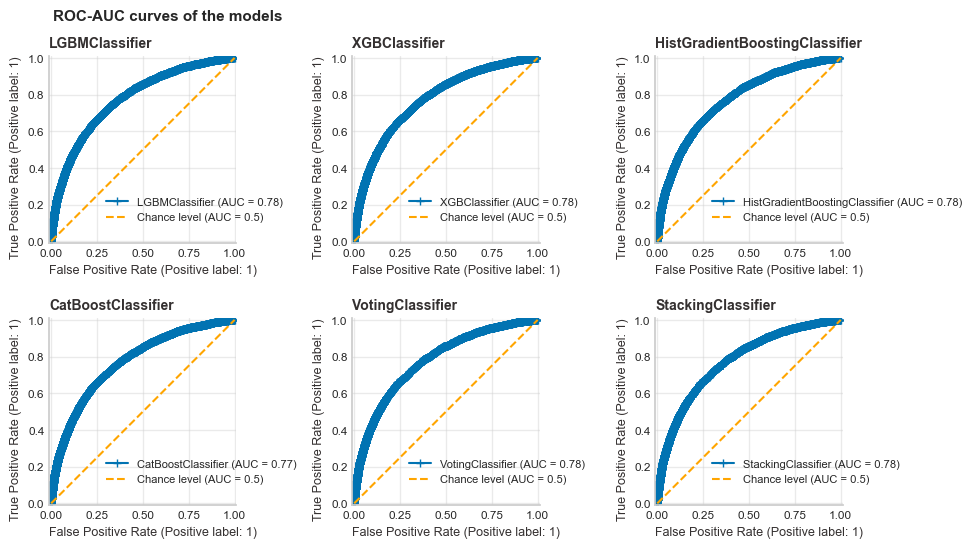

In [165]:
test_scores = utils.make_roc_auc_curve(
    fitted_pipes,
    ncols=3,
    X_test=X_test,
    y_test=y_test,
    right=0.26,
    top=0.96,
    figsize=(11, 2.5 * len(fitted_pipes) / 3),
    legend_coord=(0.25, 0.3),
    wspace=0.23,
    hspace=0.4,
    save=True,
    name="../reports/figures/roc_auc_all_models.png",
)

We see that all models have a very similar generalization performance up to 0.77-0.78, except baseline Logistic Regression model that has the lowest ROC AUC score of 0.76.

In [166]:
pipe_log_reg.fit(X_train, y_train)
y_pred_proba = pipe_log_reg.predict_proba(X_test)[:, 1]
score = round(roc_auc_score(y_test, y_pred_proba), 4)
test_scores.loc["LogisticRegression"] = score

test_scores

Test ROC AUC
VotingClassifier                      0.7790
StackingClassifier                    0.7790
LGBMClassifier                        0.7788
XGBClassifier                         0.7781
HistGradientBoostingClassifier        0.7756
CatBoostClassifier                    0.7737
LogisticRegression                    0.7563

Also we will visualize feature importance for the best performing base models to understand which features have the most influence on the predictions.

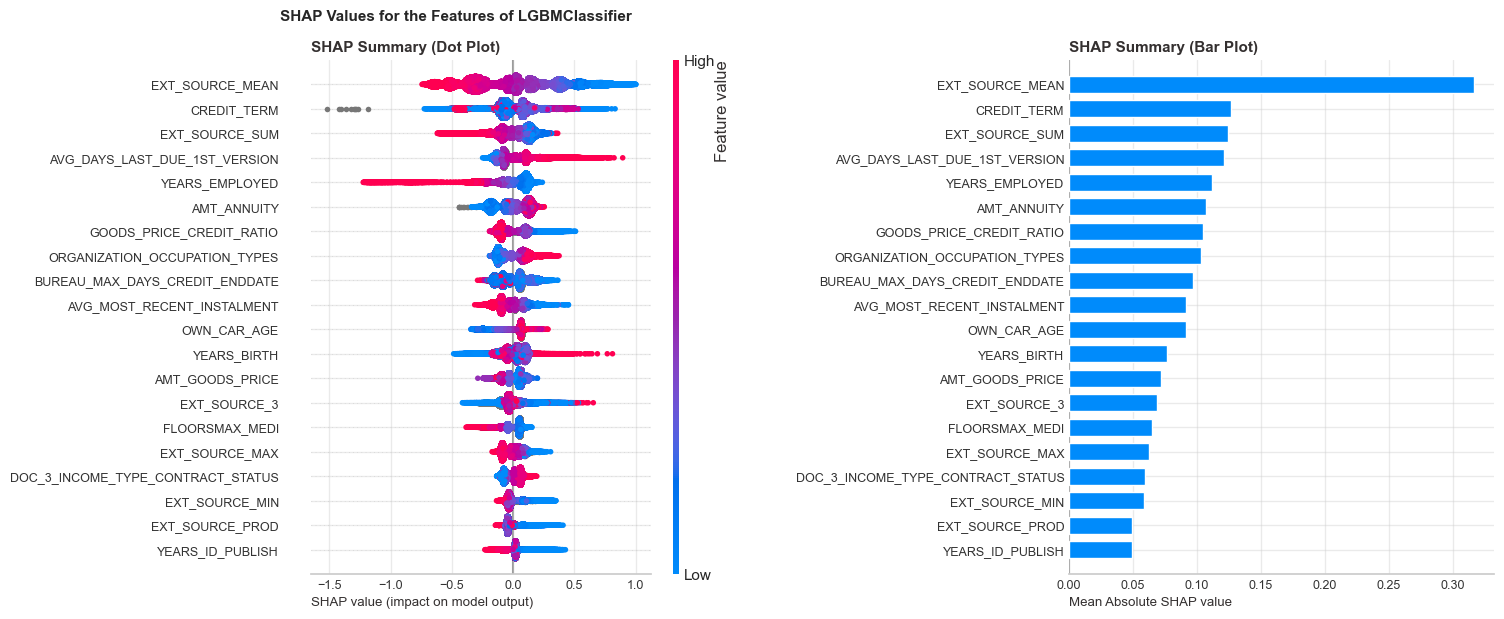

In [125]:
utils.get_shap_feat_importance(
    lgbm_pipe, X_train, y_train, figsize=(10, 4), right=0.68, top=0.95
)

We see that mean of EXT_SOURCE ratings has the highest feature importance for LightGBM model. Increase of EXT_SOURCE rate, years of employment, decrease in annuity amount and average days last due decreases the risk of default according to SHAP values.

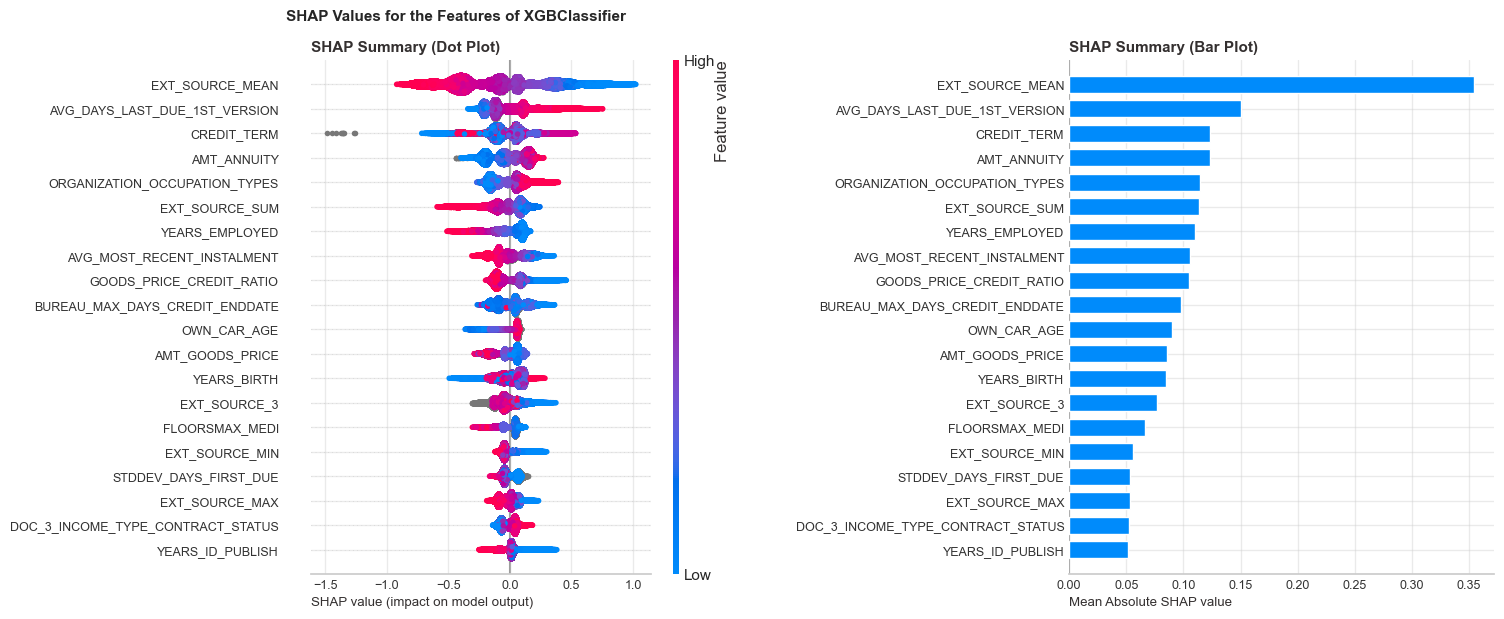

In [126]:
utils.get_shap_feat_importance(
    xgb_pipe, X_train, y_train, figsize=(10, 4), right=0.68, top=0.95
)

For XGBoost Classifier EXT_SOURCE_MEAN is also the most significant feature. Increase in the mean of the EXT_SOURCE, decrease in average days last due, annuity amount, and own car age, increase in years employed reduces the risk of default.

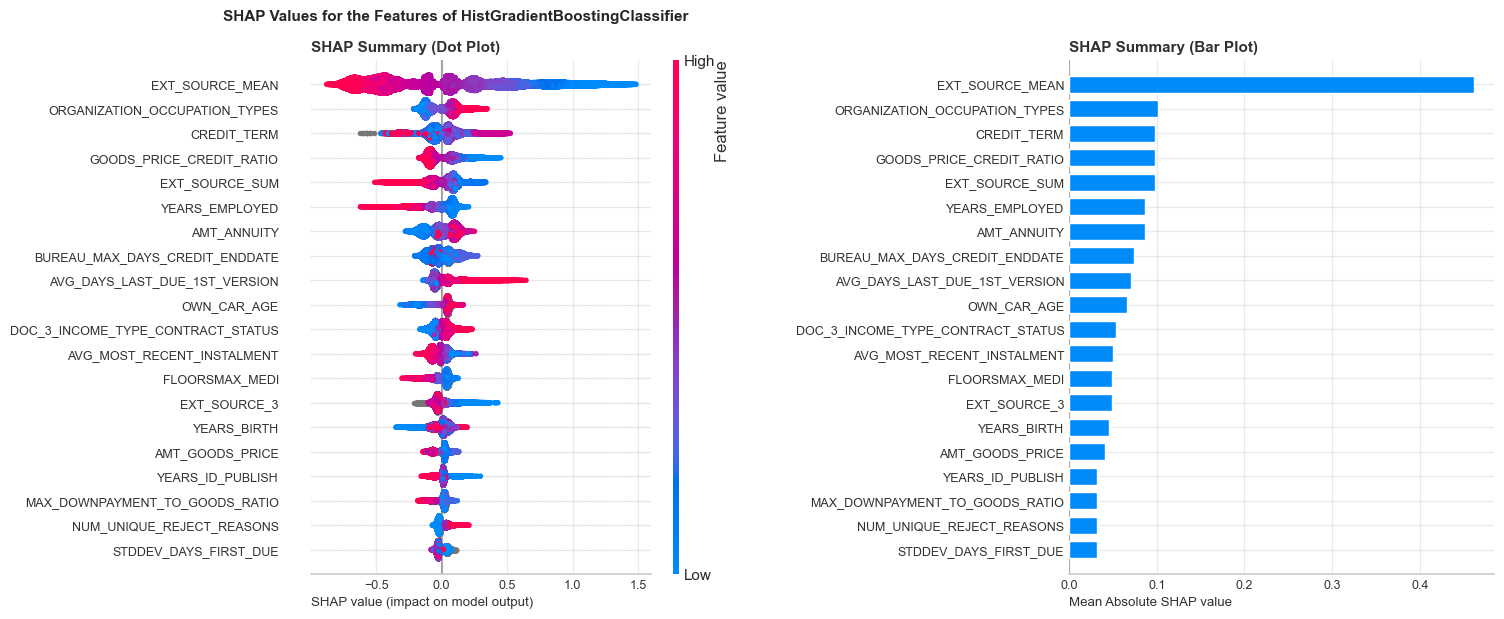

In [127]:
utils.get_shap_feat_importance(
    hgb_pipe,
    X_train,
    y_train,
    figsize=(10, 4),
    right=0.68,
    top=0.95,
)

HistGradientBoosting Classifier also relies most on EXT_SOURCE_MEAN feature, the higher it is, the lower the risk of defaulting. As for previous models, the longer years employed, the higher EXT_SOURCE rates, the lower annuity amount, and own car age, the lower the risk of default.

Finally, we will check generalization performance of the models on the final application_test dataset submitting predictions to the Kaggle platform.

In [128]:
application_test = pd.read_parquet("../data/application_test.parquet")
print(f"The shape of the final test set for  submission is: {application_test.shape}")

The shape of the final test set for  submission is: (48744, 121)


In [129]:
utils.make_predictions_save_file(
    pipe_log_reg, X, y, application_test, file_prefix="log_reg_baseline"
)

Old submission file removed: ../data/submissions/log_reg_baseline_predictions.csv.
Submission file created successfully.


In [130]:
utils.make_predictions_save_file(
    lgbm_pipe, X, y, application_test, file_prefix="lgbm_model_v4"
)

Old submission file removed: ../data/submissions/lgbm_model_v4_predictions.csv.
Submission file created successfully.


In [131]:
utils.make_predictions_save_file(xgb_pipe, X, y, application_test, file_prefix="xgb_model_v4")

Old submission file removed: ../data/submissions/xgb_model_v4_predictions.csv.
Submission file created successfully.


In [144]:
utils.make_predictions_save_file(catb_pipe, X, y, application_test, file_prefix="catb_model_v4")

Submission file created successfully.


In [133]:
utils.make_predictions_save_file(
    hgb_pipe, X, y, application_test, file_prefix="hgb_model_v4"
)

Old submission file removed: ../data/submissions/hgb_model_v4_predictions.csv.
Submission file created successfully.


In [134]:
utils.make_predictions_save_file(
    stack_model, X, y, application_test, file_prefix="stack_model_v4"
)

Old submission file removed: ../data/submissions/stack_model_v4_predictions.csv.
Submission file created successfully.


In [135]:
utils.make_predictions_save_file(
    voting_model, X, y, application_test, file_prefix="voting_model_v4"
)

Old submission file removed: ../data/submissions/voting_model_v4_predictions.csv.
Submission file created successfully.


Below we will add final model generalization ROC AUC scores on the application_test dataset to our previous comparison table.

In [167]:
final_test_scores = {
    "LGBMClassifier": 0.77009,
    "XGBClassifier": 0.77197,
    "HistGradientBoostingClassifier": 0.76833,
    "CatBoostClassifier": 0.76588,
    "VotingClassifier": 0.77149,
    "StackingClassifier": 0.77111,
    "LogisticRegression": 0.74618,
}

final_test_scores = pd.DataFrame.from_dict(
    final_test_scores, orient="index", columns=["Final Test ROC AUC"]
)
train_scores_df = train_scores_df.drop(columns=["Train Std"])
result_summary = train_scores_df.join(test_scores).join(final_test_scores)

result_summary.sort_values(by="Final Test ROC AUC", ascending=False).map(
    lambda x: f"{x:.4f}"
)

Train ROC AUC Test ROC AUC Final Test ROC AUC
XGBClassifier                         0.7727       0.7781             0.7720
VotingClassifier                      0.7740       0.7790             0.7715
StackingClassifier                    0.7737       0.7790             0.7711
LGBMClassifier                        0.7738       0.7788             0.7701
HistGradientBoostingClassifier        0.7687       0.7756             0.7683
CatBoostClassifier                    0.7662       0.7737             0.7659
LogisticRegression                    0.7519       0.7563             0.7462

Here we got the list of ROC AUC scores of the tuned models  - learning performance, generalization performance on the hold-out test set, and final test dataset. We will visualize those scores to better grasp the trends and identify the best performing model.

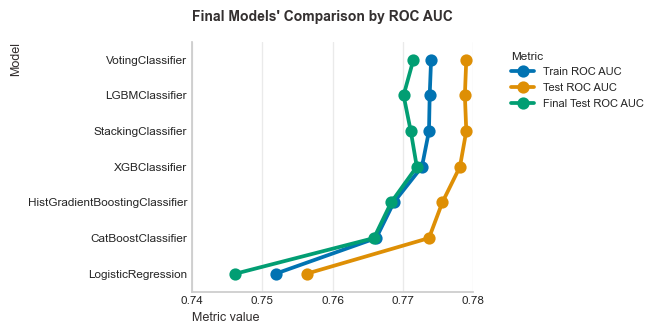

In [230]:
utils.plot_final_model_results(
    result_summary.reset_index().rename(columns={"index": "Model"}),
    figsize=(7, 3.5),
    title="Final Models' Comparison by ROC AUC",
    limits=(0.74, 0.78),
    metrics=["Train ROC AUC", "Test ROC AUC", "Final Test ROC AUC"],
    save=True,
    name="../reports/figures/final_models_comparison_roc_auc.png",
)

We see learning performance of the models using cross-validation ROC AUC scores are very similar to generalization performance on the final test set using ROC AUC scores. So we can say that models are likely well-regularized and quite stable, neither overfitting nor underfitting the data. It is interesting that models performed slightly better on hold-out test set (20% of train set) than on cross-validated train set, which may indicate that hold-out test set had slightly easier samples to predict.

As the best peforming model we will nominate XGBoost model, which achieved ROC AUC score of 0.772 on the final test set. So we can say that if we would randomly pick one positive example and one negative, the model will correctly assign higher probability to the positive example 77.2% of the time. So we have got quite good and reasonable discrimination score for our home credit default risk model.

#### **Model deployment** ####

In the last section we will prepare the best performing model for deployment using FastAPI and Docker to Google Cloud Platform, enabling scalable production use.

Since not all features are used from train set, we will adapt the preprocessing pipeline to select only those features which were used in the final model and place certain transformers to the *ml_app/app_utils* folder for the data preprocessing pipeline of the model to be deployed.

In [138]:
input_features = [
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
    "NAME_INCOME_TYPE",
    "SK_ID_CURR",
    "FLAG_DOCUMENT_3",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "OWN_CAR_AGE",
    "DAYS_EMPLOYED",
    "DAYS_BIRTH",
    "DAYS_ID_PUBLISH",
    "FLOORSMAX_MEDI",
    "CNT_FAM_MEMBERS",
]

train_columns = X_train.columns.to_list()
redundant_train_cols = set(train_columns).difference(set(input_features))
drop_feat_deploy = set(drop_feat).difference(set(redundant_train_cols))

In [139]:
mappings_deploy = {
    "NAME_INCOME_TYPE": income_mapping,
    "OCCUPATION_TYPE": occupation_mapping,
    "ORGANIZATION_TYPE": organization_mapping,
}

cols_to_cap_deploy = [
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
]

feat_clean_pipe_deploy = Pipeline(
    steps=[
        ("categorical_aggregator", CategoricalAggregator(mappings=mappings_deploy)),
        (
            "outlier_skew_transformer",
            OutlierSkewTransformer(
                columns=cols_to_cap_deploy, verbose=False, log_transform=False
            ),
        ),
        ("new_feature_engineering", NewFeatureEngineerDeploy()),
        ("days_to_years_transformer", DaysToYearsTransformer()),
    ]
)

final_prep_pipe_deploy = [
    ("feat_clean_pipe", feat_clean_pipe_deploy),
    ("table_merger", TableMerger(tables=table_dict)),
    ("feature_dropper", FeatureDropper(features_to_drop=drop_feat_deploy)),
    ("categorical_converter", CategoricalConverter(verbose=False)),
    ("preprocessor", preprocessor_gbm_v2),
    ("feature_interactions", FeatureInteractionsBorutaDeploy()),
    ("numeric_downcaster", NumericDowncaster(verbose=False)),
]

final_pipe_deploy = Pipeline(
    steps=final_prep_pipe_deploy
    + [("classifier", xg.XGBClassifier(**best_params_xgb, n_jobs=-1))]
)

Below we will check the input feature set from the training subset.

In [140]:
X_deploy = X[input_features]
X_deploy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OCCUPATION_TYPE    211120 non-null  object 
 1   ORGANIZATION_TYPE  307511 non-null  object 
 2   NAME_INCOME_TYPE   307511 non-null  object 
 3   SK_ID_CURR         307511 non-null  int64  
 4   FLAG_DOCUMENT_3    307511 non-null  int64  
 5   AMT_CREDIT         307511 non-null  float64
 6   AMT_ANNUITY        307499 non-null  float64
 7   AMT_GOODS_PRICE    307233 non-null  float64
 8   EXT_SOURCE_1       134133 non-null  float64
 9   EXT_SOURCE_2       306851 non-null  float64
 10  EXT_SOURCE_3       246546 non-null  float64
 11  OWN_CAR_AGE        104582 non-null  float64
 12  DAYS_EMPLOYED      307511 non-null  int64  
 13  DAYS_BIRTH         307511 non-null  int64  
 14  DAYS_ID_PUBLISH    307511 non-null  int64  
 15  FLOORSMAX_MEDI     154491 non-null  float64
 16  CN

We will fit the pipeline and see all the preprocessing steps applied to a sample of the data.

In [141]:
final_pipe_deploy.fit(X_deploy, y)

Pipeline(steps=[('feat_clean_pipe',
                 Pipeline(steps=[('categorical_aggregator',
                                  CategoricalAggregator(mappings={'NAME_INCOME_TYPE': {'Businessman': 'Employed',
                                                                                       'Commercial associate': 'Commercial '
                                                                                                               'associate',
                                                                                       'Maternity leave': 'Not-Employed',
                                                                                       'Pensioner': 'Pensioner',
                                                                                       'State servant': 'State '
                                                                                                        'servant',
                                                                                       'Student': 'Not-Employed',
                                                                                       'Unemployed': 'Not-Employed',
                                                                                       'Working'...
                               gamma=2.613239340401714, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.042074664281129354, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None,
                               min_child_weight=40.54694460874869, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1161, n_jobs=-1,
                               num_parallel_tree=None, ...))])

We will check if our final model works as expected predicting on a sample of the data. And we wee that it does.

In [142]:
rows = X_deploy.iloc[0:5]
final_pipe_deploy.predict_proba(rows)[:, 1]

array([0.3549489 , 0.05520631, 0.02503067, 0.0520703 , 0.04724995],
      dtype=float32)

We will save the model and the preprocessing pipeline using joblib for later use in the FastAPI application, model containerization, and deployment.

In [231]:
best_model = final_pipe_deploy
model_path = "../ml_app/xgb_model.joblib"

if os.path.exists(model_path):
    os.remove(model_path)
    print(f"Old model removed: {model_path}")

joblib.dump(best_model, model_path, compress=("xz", 3))
print(f"Model saved to: {model_path}")

Model saved to: ../ml_app/xgb_model.joblib


The model was successfully deployed to Google Cloud Platform using FastAPI and Docker containerization. It is now ready for scalable production use, allowing Home Credit to effectively assess default risk for loan applicants and promote financial inclusion.
Service URL: https://home-credit-848238844727.europe-west1.run.app

For future reference, here are the commands to build and redeploy the Docker image to Google Cloud Run in case future iterations of the model are made.
To deploy a new revision [x] of the same service [home-credit] in project [home-credit-default-app] region [europe-west1], one should run in the terminal:

* docker buildx build --platform linux/amd64 -t \
  europe-west1-docker.pkg.dev/home-credit-default-app/home-credit-repo/home_credit:v[x] .

* docker push europe-west1-docker.pkg.dev/home-credit-default-app/home-credit-repo/home_credit:v[x]

* gcloud run deploy home-credit \
  --image=europe-west1-docker.pkg.dev/home-credit-default-app/home-credit-repo/home_credit:v[x] \
  --region=europe-west1 \
  --platform=managed \
  --allow-unauthenticated \
  --memory=2Gi

#### **Conclusion** ####

There are several key takeaways from the Home Credit Default Risk project:
1. **Data Understanding and Preprocessing**: Comprehensive exploratory data analysis (EDA) and preprocessing steps were crucial in understanding the datasets, handling missing values, outliers, and feature engineering. This laid a solid foundation for effective modeling. It was noticed that too strict winsorization of highly skewed features which were aggregated later led to loss of important information and reduced model learning performance, so a balanced approach was taken.

2. **Feature Selection**: The use of Boruta SHAP feature selection helped identify the most relevant features, reducing dimensionality and improving model interpretability without sacrificing predictive power. 

3. **Statistical Inference**: Conducting statistical tests validated the significance of selected features and informed feature interaction engineering, enhancing model robustness. Also, this enabled to identify a few redundant features making no harm to the predictive power of the models.

4. **Modeling Approach**: Gradient boosting models (LightGBM, XGBoost, CatBoost, HistGradientBoosting) were chosen for their ability to handle missing data, mixed data types, imbalanced datasets, and complex relationships. Hyperparameter tuning using Optuna further enhanced model performance. Logistic Regression was used as a baseline model to benchmark performance.

5. **Model Evaluation**: Rigorous evaluation using cross-validation and hold-out test sets ensured that the models generalized well to unseen data. The final test on the test subset proved that the models are stable and robust. The XGBoost model provided the best performance with a ROC AUC score of 0.772 on the final test set, compared to baseline Logistic Regression model ROC AUC score of 0.746. However, generalization performance on the hold-out test set was slightly better than on the cross-validated train set, indicating that the hold-out test set had slightly easier samples to predict, but lower than generalization performance on the final test set from Kaggle platform.

6. **Feature Importance**: Default risk seems to have the highest correlation wit EXT_SOURCE ratings, and credit card utilization ratios. Clients having greater annuity amount, shorter employment history, older car and more family members tend to have a higher risk of defaulting. All gradient boosted models mostly rely on the mean of EXT_SOURCE ratings.

7. **Deployment**: The successful deployment of the best-performing XGBoost model using FastAPI and Docker to Google Cloud Platform demonstrated the project's practical applicability, enabling scalable production use.

#### **Suggestions for Improvement** ####

There are still a lot that could be experimented with and improved in this project. Below are some suggestions for further improvement:

* Experiment with handling skewness of numerical features using different transformations instead of winsorization of only selected features.

* Try non-tree based models like SVM, KNN, Logistic Regression with feature interactions.

* Examine if oversampling and undersampling could improve predictive performance of the model.

* Experiment with different feature encoding techniques for categorical features.

* Try removing more multicollinear features based on correlation analysis to reduce feature redundancy.

* Experiment with different missing values, outliers and anomaly detection and handling techniques, especially in the helper tables. Also applying different aggregations to helper tables.

* Explore additional feature engineering techniques, including polynomial features, clustering-based features, or domain-specific transformations.